# Data Wrangling: *WeRateDogs* Twitter Data 

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**Changing the display options**

Using the [pandas set_option](https://www.geeksforgeeks.org/pandas-reset_option-function-in-python/)

In [4]:
pd.reset_option('display.float_format')

In [5]:
# Showing the full text (content) in a given column
pd.set_option('display.max_colwidth', None)

In [6]:
# displaying all columns without trunction
pd.set_option('display.max_columns', None)

## Data Gathering 

###  Twitter archive and image prediction data gathering

In [7]:
# Twitter archive data (read from csv file)
archive = pd.read_csv('twitter-archive-enhanced.csv')

# Image prediction data (read from csv file hosted in a link)

image_predictions = pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', sep='\t')

In [8]:
# Checking the data 
archive.head(3)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   

                                                                               source  \
0  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                 text  \
0                                                       This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   
2                   This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB   

   retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
0                  NaN                       NaN                        NaN   
1                  NaN                       NaN                        NaN   
2                  NaN                       NaN                        NaN   

                                                     expanded_urls  \
0  https://twitter.com/dog_rates/status/892420643555336193/photo/1   
1  https://twitter.com/dog_rates/status/892177421306343426/photo/1   
2  https://twitter.com/dog_rates/status/891815181378084864/photo/1   

   rating_numerator  rating_denominator     name doggo floofer pupper puppo  
0                13                  10  Phineas  None    None   None  None  
1                13                  10    Tilly  None    None   None  None  
2                12                  10   Archie  None    None   None  None

In [9]:
image_predictions.head(3)

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True

In [10]:
# Downloading and saving the image prediction data using Requests

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
file_name = url.split('/')[-1]
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(r.content)

### Twitter API Data for the favourites and retweets counts

**Note**: The following code requires inserting twitter developer credentials. This task was done as part of the project then my credentials were removed. 

In [6]:
# Accessing twitter api 
import config 
consumer_key = '**************'
consumer_secret = '******************'
access_token = '***************************'
access_secret = '************'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Confirming a successful twitter api access

In [7]:
# Experimenting to extract one tweet's id information

exp_tweet = api.get_status(archive.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
content

{'created_at': 'Wed Jun 29 01:23:16 +0000 2016',
 'id': 747963614829678593,
 'id_str': '747963614829678593',
 'full_text': 'PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q',
 'truncated': False,
 'display_text_range': [0, 70],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 747963600220917761,
    'id_str': '747963600220917761',
    'indices': [71, 94],
    'media_url': 'http://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'url': 'https://t.co/ZPfeRtOX0Q',
    'display_url': 'pic.twitter.com/ZPfeRtOX0Q',
    'expanded_url': 'https://twitter.com/dog_rates/status/747963614829678593/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 937, 'h': 632, 'resize': 'fit'},
     'small': {'w': 680, 'h': 459, 'resize': 'fit'},
     'large': {'w': 937, 'h': 632, '

In [8]:
content.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [9]:
# Getting the retweet and favorite counts
content['retweet_count'] , content['favorite_count']

(2271, 6019)

In [10]:
#investigating the user information
content['user'].keys()

dict_keys(['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url', 'entities', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'utc_offset', 'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'is_translator', 'is_translation_enabled', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_image_url', 'profile_image_url_https', 'profile_banner_url', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'following', 'follow_request_sent', 'notifications', 'translator_type'])

In [11]:
# Examining some attributs of the users
content['user']['followers_count'], content['user']['location']

(7909197, '「 DM YOUR DOGS 」')

In [12]:
# Creating a file for the additional tweets text data
if not os.path.isfile('tweet_json.txt'):
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in archive['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

In [11]:
# read the tweet_json.txt file and constructing a list of all tweets
tweets = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweets.append(tweet)
        
tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [12]:
# Building the dataframe from the api data
api_df = pd.DataFrame()

api_df['id'] = list(map(lambda tweet: tweet['id'], tweets))
api_df['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets))
api_df['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets))
api_df['followers_count'] = list(map(lambda tweet: tweet['user']['followers_count'], tweets))


In [13]:
api_df.head()

id  retweet_count  favorite_count  followers_count
0  892420643555336193           8222           37732          7895159
1  892177421306343426           6077           32401          7895160
2  891815181378084864           4023           24405          7895160
3  891689557279858688           8377           41049          7895161
4  891327558926688256           9081           39244          7895161

In [14]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2336 entries, 0 to 2335
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               2336 non-null   int64
 1   retweet_count    2336 non-null   int64
 2   favorite_count   2336 non-null   int64
 3   followers_count  2336 non-null   int64
dtypes: int64(4)
memory usage: 73.1 KB


## Data Assessment

That's where the inspection of our collected data sets from both the ***Quality*** and ***Tidiness*** perspectives will be conducted.

- Data quality dimensions help guide the thought process while assessing and also cleaning. The four main data quality dimensions are:

    -  Completeness: do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?
    -  Validity: we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
    -  Accuracy: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.
    -  Consistency: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

##### Dimensions of the 3 datasets:

In [15]:
print("archive: \n" + str(archive.shape) + "\n" + 'image_predictions: \n' + str(image_predictions.shape) + '\n' + 'api_df: \n' + str(api_df.shape))

archive: 
(2356, 17)
image_predictions: 
(2075, 12)
api_df: 
(2336, 4)


### The Twitter *`archive`* table:

In [16]:

archive


tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
...                  ...                    ...                  ...   
2351  666049248165822465                    NaN                  NaN   
2352  666044226329800704                    NaN                  NaN   
2353  666033412701032449                    NaN                  NaN   
2354  666029285002620928                    NaN                  NaN   
2355  666020888022790149                    NaN                  NaN   

                      timestamp  \
0     2017-08-01 16:23:56 +0000   
1     2017-08-01 00:17:27 +0000   
2     2017-07-31 00:18:03 +0000   
3     2017-07-30 15:58:51 +0000   
4     2017-07-29 16:00:24 +0000   
...                         ...   
2351  2015-11-16 00:24:50 +0000   
2352  2015-11-16 00:04:52 +0000   
2353  2015-11-15 23:21:54 +0000   
2354  2015-11-15 23:05:30 +0000   
2355  2015-11-15 22:32:08 +0000   

                                                                                  source  \
0     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
4     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
...                                                                                  ...   
2351  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2352  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2353  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2354  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2355  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                    text  \
0                                                          This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   
1     This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   
2                      This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB   
3                                                                This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ   
4     This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f   
...                                                                                                                                                                  ...   
2351                                            Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq   
2352                           This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx   
2353                                  Here is a very happy pup. Big fan of we

In [17]:
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [18]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [20]:
# Are all or most of dogs classified
print(archive.doggo.value_counts(), '\n') 
print(archive.floofer.value_counts(),'\n')
print(archive.pupper.value_counts(),'\n')
print(archive.puppo.value_counts())

None     2259
doggo    97  
Name: doggo, dtype: int64 

None       2346
floofer    10  
Name: floofer, dtype: int64 

None      2099
pupper    257 
Name: pupper, dtype: int64 

None     2326
puppo    30  
Name: puppo, dtype: int64


In [21]:
(archive.loc[:, 'doggo':"puppo"] != 'None') .sum()

doggo      97 
floofer    10 
pupper     257
puppo      30 
dtype: int64

In [22]:
#Is the classification correct and mutually exclusive
# https://stackoverflow.com/questions/42461086/subset-pandas-dataframe-using-values-from-two-columns
nonunique_stage = archive[(archive['doggo'] != 'None') & (archive['pupper'] != 'None')]
nonunique_stage.iloc[:, -4:].head()

doggo floofer  pupper puppo
460  doggo  None    pupper  None
531  doggo  None    pupper  None
565  doggo  None    pupper  None
575  doggo  None    pupper  None
705  doggo  None    pupper  None

In [54]:
# Checking the most frequent names
archive.name.value_counts().head(10)

None       745
a          55 
Charlie    12 
Cooper     11 
Lucy       11 
Oliver     11 
Tucker     10 
Penny      10 
Lola       10 
Winston    9  
Name: name, dtype: int64

In [55]:
# Checking the names less than 3 letters
archive[archive['name'].str.len() < 3].name.value_counts()

a     55
Bo    9 
an    7 
Mo    1 
O     1 
Al    1 
my    1 
by    1 
Ed    1 
JD    1 
Jo    1 
Name: name, dtype: int64

In [24]:
# Checking the name column in comparison with the text
archive.loc[:,['text', 'name']].sample(10)

text  \
653   This is Remus. He's a mop that came to life. Can't see anything. Constantly trips over himself. Still a very good dog. 11/10 https://t.co/S3f1SYylzu                   
166   Meet Milky. She has no idea what happened. Just as pupset as you. Perhaps a sheep exploded. Even offered to help clean. 12/10 very good girl https://t.co/g8vpXFzw29   
1285  This is Bobble. He's a Croatian Galifianakis. Hears everything within 400 miles. 11/10 would snug diligently https://t.co/VwDc6PTDzk                                   
362   Here's a stressed doggo. Had a long day. Many things on her mind. The hat communicates these feelings exquisitely. 11/10 https://t.co/fmRS43mWQB                       
914   Here's a doggo completely oblivious to the double rainbow behind him. 10/10 someone tell him https://t.co/OfvRoD6ndV                                                   
1992  This is Norman. Doesn't bark much. Very docile pup. Up to date on current events. Overall nifty pupper. 6/10 https://t.co/ntxsR98f3U                                   
1268  This is Cecil. She's a Gigglefloof Poofer. Outdoorsy af. One with nature. 12/10 would strategically capture https://t.co/ijJB0DuOIC                                    
52    This is Koko. Her owner, inspired by Barney, recently built a cart for her to use during walks if she got tired. 13/10 rest easy Koko https://t.co/zeDpnsKX7w          
1791  Downright inspiring 12/10 https://t.co/vSLtYBWHcQ                                                                                                                      
755   This is Mya (pronounced "mmmyah?"). Her head is round af. 11/10 would pat accordingly https://t.co/1dpEuALnY0                                                          

        name  
653   Remus   
166   Milky   
1285  Bobble  
362   None    
914   None    
1992  Norman  
1268  Cecil   
52    Koko    
1791  None    
755   Mya

In [25]:
archive.loc[:,['text', 'name']][(archive['name'] == 'None')].sample(10)

text  \
436   We are proud to support @LoveYourMelon on their mission to put a hat on every kid battling cancer. They are 14/10\n\nhttps://t.co/XQlmPTLHPl https://t.co/ZNIkkHgtYE   
1304  "I shall trip the big pupper with leash. Big pupper will never see it coming. I am a genius." Both 11/10 https://t.co/uQsCJ8pf51                                       
1091  Just wanted to share this super rare Rainbow Floofer in case you guys haven't seen it yet. 13/10 colorful af https://t.co/CaG9MzD3WT                                   
37    Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf         
1942  🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10 https://t.co/MTOOksRzvH                                                                                                     
868   RT @dog_rates: "Tristan do not speak to me with that kind of tone or I will take away the Xbox." 10/10 https://t.co/VGPH0TfESw                                         
133   He was providing for his family 13/10 how dare you https://t.co/Q8mVwWN3f4                                                                                             
1517  She thought the sunset was pretty, but I thought she was prettier. 10/10 https://t.co/HSL3mnP5NX                                                                       
1966  IT'S SO SMALL ERMERGERF 11/10 https://t.co/dNUbKOSiWW                                                                                                                  
402   Retweet the h*ck out of this 13/10 pupper #BellLetsTalk https://t.co/wBmc7OaGvS                                                                                        

      name  
436   None  
1304  None  
1091  None  
37    None  
1942  None  
868   None  
133   None  
1517  None  
1966  None  
402   None

In [56]:
# Are all names capitalized.
archive.name.str.islower().sum()

109

In [57]:
# Seems that the way the names are captured is by 
# scraping the word after the "this is" or the word "meet"
archive.loc[[1049] ,['text', 'name']]

text  \
1049  This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa   

     name  
1049  a

In [58]:
# some texts contain more than one name:
archive.loc[[1007] ,['text', 'name']]

text  \
1007  This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ   

           name  
1007  Bookstore

In [60]:
# Some names weren't successfully captured from the text
archive.loc[[391,1501] ,['text', 'name']]

text  \
391   Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10 \nhttps://t.co/1httNYrCeW https://t.co/KvaM8j3jhX   
1501  These are some pictures of Teddy that further justify his 13/10 rating. Please enjoy https://t.co/tDkJAnQsbQ                                    

      name  
391   None  
1501  None

In [61]:
# Checking the ratings values
archive.loc[:, ['rating_numerator', 'rating_denominator']].describe()

rating_numerator  rating_denominator
count  2356.000000       2356.000000       
mean   13.126486         10.455433         
std    45.876648         6.745237          
min    0.000000          0.000000          
25%    10.000000         10.000000         
50%    11.000000         10.000000         
75%    12.000000         10.000000         
max    1776.000000       170.000000

In [62]:
archive.rating_denominator.sort_values()

313     0  
2335    2  
516     7  
1576    10 
1575    10 
        .. 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [63]:
archive.rating_numerator.sort_values()

315     0   
1016    0   
2335    1   
2261    1   
2338    1   
       ..   
2074    420 
188     420 
189     666 
313     960 
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [64]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

### The *`image_predictions`* table

In [65]:
image_predictions.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0  1        Welsh_springer_spaniel  0.465074  True    collie               
1  1        redbone                 0.506826  True    miniature_pinscher   
2  1        German_shepherd         0.596461  True    malinois             
3  1        Rhodesian_ridgeback     0.408143  True    redbone              
4  1        miniature_pinscher      0.560311  True    Rottweiler           

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665  True    Shetland_sheepdog    0.061428  True    
1  0.074192  True    Rhodesian_ridgeback  0.072010  True    
2  0.138584  True    bloodhound           0.116197  True    
3  0.360687  True    miniature_pinscher   0.222752  True    
4  0.243682  True    Doberman             0.154629  True

In [66]:
image_predictions.sample(15)

tweet_id  \
2068  890971913173991426   
1260  748705597323898880   
67    667177989038297088   
1987  872620804844003328   
1760  825876512159186944   
391   673576835670777856   
792   690728923253055490   
484   675483430902214656   
386   673350198937153538   
1363  761334018830917632   
1997  875021211251597312   
675   683449695444799489   
1851  840370681858686976   
834   694001791655137281   
1897  850380195714523136   

                                                                                      jpg_url  \
2068  https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg                                           
1260  https://pbs.twimg.com/ext_tw_video_thumb/748704826305970176/pu/img/QHuadM5eEygfBeOf.jpg   
67    https://pbs.twimg.com/media/CUJK18UWEAEg7AR.jpg                                           
1987  https://pbs.twimg.com/media/DBwr_hzXkAEnZBW.jpg                                           
1760  https://pbs.twimg.com/media/C3YaSnQWAAILgz0.jpg                                           
391   https://pbs.twimg.com/media/CVkGjsxU8AA5OYX.jpg                                           
792   https://pbs.twimg.com/media/CZX2SxaXEAEcnR6.jpg                                           
484   https://pbs.twimg.com/media/CV_MmGZU8AAggM6.jpg                                           
386   https://pbs.twimg.com/media/CVg4bo8WEAANEEE.jpg                                           
1363  https://pbs.twimg.com/media/CpDNQGkWEAENiYZ.jpg                                           
1997  https://pbs.twimg.com/media/DCSzF3NVoAAPzT4.jpg                                           
675   https://pbs.twimg.com/media/CXwZ3pbWsAAriTv.jpg                                           
1851  https://pbs.twimg.com/media/C6mYrK0UwAANhep.jpg                                           
834   https://pbs.twimg.com/media/CaGW8JQUMAEVtLl.jpg                                           
1897  https://pbs.twimg.com/ext_tw_video_thumb/850380153985355777/pu/img/lFouhg-EZvJs8eMr.jpg   

      img_num                           p1   p1_conf  p1_dog  \
2068  1        Appenzeller                  0.341703  True     
1260  1        tiger_shark                  0.548497  False    
67    1        vizsla                       0.259249  True     
1987  1        cocker_spaniel               0.513191  True     
1760  1        shopping_cart                0.995941  False    
391   1        teddy                        0.255210  False    
792   1        kuvasz                       0.422806  True     
484   1        box_turtle                   0.543706  False    
386   1        West_Highland_white_terrier  0.119188  True     
1363  1        Norwegian_elkhound           0.822936  True     
1997  2        West_Highland_white_terrier  0.714319  True     
675   1        Lakeland_terrier             0.303512  True     
1851  1        teapot                       0.981819  False    
834   1        Pembroke                     0.769999  True     
1897  1        Yorkshire_terrier            0.249012  True     

                               p2   p2_conf  p2_dog                p3  \
2068  Border_collie                0.199287  True    ice_lolly          
1260  great_white_shark            0.130252  False   scuba_diver        
67    Chesapeake_Bay_retriever     0.176293  True    Weimaraner         
1987  Sussex_spaniel               0.159088  True    standard_poodle    
1760  shopping_basket              0.004057  False   mousetrap          
391   Christmas_stocking           0.098285  False   pajama             
792   golden_retriever             0.291586  True    Great_Pyrenees     
484   terrapin                     0.202600  False   loggerhead         
386   quill                        0.104014  False   Maltese_dog        
1363  malinois                     0.086152  True    German_shepherd    
1997  Siberian_husky               0.091913  True    Great_Pyrenees     
675   soft-coated_wheaten_terrier  0.211424  True    golden_retriever   
1851  cup                          0.014

In [67]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [68]:
# Examine all the tweets with predictions other than dogs across all three prediction levels. 
image_predictions[(image_predictions['p1_dog'] == False) & 
                  (image_predictions['p2_dog'] == False) &
                  (image_predictions['p3_dog'] == False)]

tweet_id  \
6     666051853826850816   
17    666104133288665088   
18    666268910803644416   
21    666293911632134144   
25    666362758909284353   
...                  ...   
2021  880935762899988482   
2022  881268444196462592   
2046  886680336477933568   
2052  887517139158093824   
2074  892420643555336193   

                                                                                      jpg_url  \
6     https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg                                           
17    https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg                                           
18    https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg                                           
21    https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg                                           
25    https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg                                           
...                                               ...                                           
2021  https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg                                           
2022  https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg                                           
2046  https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg                                           
2052  https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg   
2074  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg                                           

      img_num                p1   p1_conf  p1_dog               p2   p2_conf  \
6     1        box_turtle        0.933012  False   mud_turtle       0.045885   
17    1        hen               0.965932  False   cock             0.033919   
18    1        desktop_computer  0.086502  False   desk             0.085547   
21    1        three-toed_sloth  0.914671  False   otter            0.015250   
25    1        guinea_pig        0.996496  False   skunk            0.002402   
...  ..               ...             ...    ...     ...                 ...   
2021  1        street_sign       0.251801  False   umbrella         0.115123   
2022  1        tusker            0.473303  False   Indian_elephant  0.245646   
2046  1        convertible       0.738995  False   sports_car       0.139952   
2052  1        limousine         0.130432  False   tow_truck        0.029175   
2074  1        orange            0.097049  False   bagel            0.085851   

      p2_dog              p3   p3_conf  p3_dog  
6     False   terrapin        0.017885  False   
17    False   partridge       0.000052  False   
18    False   bookcase        0.079480  False   
21    False   great_grey_owl  0.013207  False   
25    False   hamster         0.000461  False   
...     ...       ...              ...    ...   
2021  False   traffic_light   0.069534  False   
2022  False   ibex            0.055661  False   
2046  False   car_wheel       0.044173  False   
2052  False   shopping_cart   0.026321  False   
2074  False   banana          0.076110  False   

[324 rows x 12 columns]

In [69]:
image_predictions.p1.value_counts().head(15)

golden_retriever            150
Labrador_retriever          100
Pembroke                    89 
Chihuahua                   83 
pug                         57 
chow                        44 
Samoyed                     43 
toy_poodle                  39 
Pomeranian                  38 
cocker_spaniel              30 
malamute                    30 
French_bulldog              26 
miniature_pinscher          23 
Chesapeake_Bay_retriever    23 
seat_belt                   22 
Name: p1, dtype: int64

In [70]:
image_predictions.p2.value_counts().head(15)

Labrador_retriever          104
golden_retriever            92 
Cardigan                    73 
Chihuahua                   44 
Pomeranian                  42 
Chesapeake_Bay_retriever    41 
French_bulldog              41 
toy_poodle                  37 
cocker_spaniel              34 
miniature_poodle            33 
Siberian_husky              33 
beagle                      28 
Pembroke                    27 
Eskimo_dog                  27 
collie                      27 
Name: p2, dtype: int64

In [71]:
image_predictions.p3.value_counts().head(15)

Labrador_retriever           79
Chihuahua                    58
golden_retriever             48
Eskimo_dog                   38
kelpie                       35
kuvasz                       34
Staffordshire_bullterrier    32
chow                         32
beagle                       31
cocker_spaniel               31
Pomeranian                   29
toy_poodle                   29
Pekinese                     29
Chesapeake_Bay_retriever     27
Great_Pyrenees               27
Name: p3, dtype: int64

In [41]:
# Predictions summary
image_predictions.loc[:,['p1_conf', 'p2_conf', 'p3_conf']].describe()

p1_conf       p2_conf       p3_conf
count  2075.000000  2.075000e+03  2.075000e+03
mean   0.594548     1.345886e-01  6.032417e-02
std    0.271174     1.006657e-01  5.090593e-02
min    0.044333     1.011300e-08  1.740170e-10
25%    0.364412     5.388625e-02  1.622240e-02
50%    0.588230     1.181810e-01  4.944380e-02
75%    0.843855     1.955655e-01  9.180755e-02
max    1.000000     4.880140e-01  2.734190e-01

In [72]:
# Check whether there are instances where the second or the third predictions are of higher accruacy than the first
np.logical_or(image_predictions.p1_conf < image_predictions.p2_conf, image_predictions.p1_conf < image_predictions.p3_conf).sum()

0

### The twitter *`api_df`* table

In [73]:
api_df.head()

id  retweet_count  favorite_count  followers_count
0  892420643555336193  8222           37732           7895159        
1  892177421306343426  6077           32401           7895160        
2  891815181378084864  4023           24405           7895160        
3  891689557279858688  8377           41049           7895161        
4  891327558926688256  9081           39244           7895161

In [74]:
api_df.sample(20)

id  retweet_count  favorite_count  followers_count
1333  704113298707505153  594            1922            7895269        
757   776819012571455488  14856          0               7895207        
264   840728873075638272  17074          0               7895183        
1623  684147889187209216  1581           3094            7895283        
1878  674690135443775488  482            1164            7895310        
1455  693942351086120961  387            1803            7895277        
1541  688789766343622656  699            2311            7895279        
1796  676606785097199616  458            1929            7895302        
1957  672988786805112832  299            993             7895317        
243   844979544864018432  2705           14050           7895183        
1526  689557536375177216  485            2132            7895279        
1206  714251586676113411  880            3384            7895258        
465   816014286006976512  5747           0               7895192        
1175  717790033953034240  1185           2981            7895256        
1411  697616773278015490  1067           3281            7895276        
1371  700462010979500032  1897           4303            7895837        
2187  668627278264475648  118            320             7895326        
536   805487436403003392  2753           9305            7895192        
2030  671497587707535361  453            923             7895320        
1477  692568918515392513  1621           4529            7895277

In [75]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2336 entries, 0 to 2335
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               2336 non-null   int64
 1   retweet_count    2336 non-null   int64
 2   favorite_count   2336 non-null   int64
 3   followers_count  2336 non-null   int64
dtypes: int64(4)
memory usage: 73.1 KB


In [76]:
api_df.loc[:, ['retweet_count', 'favorite_count', 'followers_count']].describe()

retweet_count  favorite_count  followers_count
count  2336.000000    2336.000000     2.336000e+03   
mean   2899.403253    7887.354452     7.895254e+06   
std    4891.636382    12230.303381    7.411801e+01   
min    0.000000       0.000000        7.895159e+06   
25%    582.250000     1363.750000     7.895195e+06   
50%    1351.500000    3428.500000     7.895256e+06   
75%    3379.250000    9658.000000     7.895294e+06   
max    82868.000000   162834.000000   7.895884e+06

### Data Warngling Scope of work
As per the project requirements; only original ratings (*no retweets*) that ***have images*** should be included

In [77]:
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [78]:
archive.retweeted_status_id.dtypes

dtype('float64')

In [79]:
# Seems that the way the names are captured is by 
# scraping the word after the strings "this is" or  "meet"
archive.loc[[1049] ,['text', 'name']]

text  \
1049  This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa   

     name  
1049  a

## Assessment summary

### Quality aspects

#### *`archive`* table

+ **Data types(consistency issues):** 
    -  All timestamps are object type
    - All tweet_ids are integers
    - Inconsistent representation of null values as "None" strings in the (name, doggo, floofer, pupper, puppo) columns.
    - The variables (in_reply_to_status_id,  in_reply_to_user_id, 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp') will not be included in our analysis, their main use will be to identify retweets(drop retweeted_status_id with non-null values) and replies (drop in_reply_to_status_id with non-null values)to exclude them. 
    
 
- **completeness isues:** 
    -  In the name column, some names weren't successfully extracted from the text e.g. idexes 391,1501 while others contain more than one name in the text while only one was extracted e.g. index 1007.
    -  Missing entries in expanded_urls. 
    - columns (in_reply_to_status_id,  in_reply_to_user_id, 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'doggo', 'floofer', 'pupper', 'puppo') include a large number of missing values.
    - Some tweets may not include any image; those should be deleted (note the discrepancy in the number of tweets between the `archive` dataset and the `image_prediction` one)
    - Some tweets are actually retweets and replies not original tweets that have to be deleted as per the data wrangling scope mandated by the project specification. (Note: those tweets should be removed from the three tables in hand)

- **Accuracy issues:**
    -  erroneous names extracted like the second most frequent name "the letter a". Those needs to be rendered null.
    - Incorrect and weird values of the rating_numerator which has a maximum of 1776.
    - The same holds for the rating_denominator with illogical maximum of 170

#### *`image_predictions`* table
- Non-descriptive columns' names
- Inconsistent capitalization for the predicted breeds(p1, p2, p3 )
- In general the total number of records (2075 instead of 2356) indicates the presence of some tweets without images which we need to exclude.

#### *`api_df`* table
- In general the total number of records (2236) indicates the presence of some tweets without relevant retweet and favorite counts. 

### Tidiness aspects:

#### *`archive`* table
- values are column names(doggo, floofer, pupper, puppo); they better be combined in one column names "dog_stage"

#### *`image_predictions`* table
- values are column names(p1,p2,p3) which are all breed predictions

#### *`api_df`* table
- This isn't considered an observational unit to have its own table; so, it should be merged to the *`archive`* table

## 3. Data Cleaning

In [80]:
# Copying the datasets 
archive_clean = archive.copy()
image_clean = image_predictions.copy()
api_clean = api_df.copy()

### Addressing the missing values in the archive dataset

**1. In the *`name`* column:**
 >   -  some names weren't successfully extracted from the text e.g. idexes 391, 1501 
     -  while others contain more than one name in the text while only one was extracted e.g. index 1007. *(This will not be addressed due as a tradeoff with keeping the dataset intact and to not jeoparadize its structure for fixing sucu a rare issue)*
     -  erroneous names extracted like the second most frequent name "the letter a". Those needs to be rendered null.
     -  Inconsistent representation of null values as "None" strings

#### Define
>-  I will firstly fix the visually detected rows manually. Dealing with the names with the string "a" value.  
-  Scrutinizing the texts that were used to extract the "a" names; i noticed a pettern in many of them that they contain the name of the dog after the word "named"; The following code will extract the name if exists and replace the value "a" with it, otherwise will set the "a" to "None".
-  Replacing the 'None' string with pythonic null values

#### Code

In [81]:
# The visually detected rows with names not correctly extracted
archive_clean.loc[[archive_clean.index[391],archive_clean.index[1501] ], ['text', 'name']]

text  \
391   Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10 \nhttps://t.co/1httNYrCeW https://t.co/KvaM8j3jhX   
1501  These are some pictures of Teddy that further justify his 13/10 rating. Please enjoy https://t.co/tDkJAnQsbQ                                    

      name  
391   None  
1501  None

In [82]:
# archive_clean.loc[archive_clean.dog_stage == "", 'dog_stage'] = np.nan
archive_clean.loc[391, 'name'] = 'Dew'
archive_clean.loc[1501, 'name'] = 'Teddy'

In [85]:
# Names with length less than 3 letters
short_names = archive_clean[(archive_clean['name'].str.len() < 3) & (archive_clean['name'] != "a")]
short_names.name.value_counts()

Bo    9
an    7
Mo    1
O     1
Al    1
my    1
by    1
Ed    1
JD    1
Jo    1
Name: name, dtype: int64

In [86]:
# Names that are two letters length
short_names[['text', 'name']]

text  \
393   This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5             
446   RT @dog_rates: This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1                     
449   This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1                                    
553   This is Bo. He's going to make me cry. 13/10 please get off the bus for him Carly https://t.co/U7FvBZo6Bq                                      
583   RT @dog_rates: This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://…   
679   This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN     
686   RT @dog_rates: This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK                                   
759   RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR   
775   This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC                          
820   Meet Al Cabone. He's a gangsta puppa. Rather h*ckin ruthless. Shows no mercy sometimes. 11/10 pet w extreme caution https://t.co/OUwWbEKOUV    
852   This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB         
876   This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK                                                  
978   This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR                                          
1025  This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt     
1362  This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR                  
1683  This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://t.co/TONMhRoQh7    
1724  This is by far the most coordinated series of pictures I was sent. Downright impressive in every way. 12/10 for all https://t.co/etzLo3sdZE    
1988  This is Ed. He's not mad, just disappointed. 10/10 https://t.co/BIljU0zhLN                                                                     
2041  This is JD (stands for "just dog"). He's like Airbud but with trading card games instead of sports. 10/10 much skill https://t.co/zzueJV9jCF   
2204  This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg    
2219  This is Jo. Jo is a Swedish Queso. Tongue bigger than face. Tiny lil legs. Still no seatbelt. Simply careless. 8/10 https://t.co/Edy7B5vOp2    
2333  This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL    
2335  This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv       
2349  This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc     

     name  
393   Mo   
446   Bo   
449   Bo   
553   Bo   
583   Bo   
679   Bo   
686   Bo   
759   an   
775   O    
820   Al   
852   my   
876   Bo   
978   Bo   
1025  an   
1362  an   
1683  Bo   
1724  by   
1988  Ed   
2041  JD   
2204  an   
2219  Jo   
2333  an   
2335  an   
2349  an

In [83]:
# Many texts have the names after the word 'named'
archive_clean[archive_clean['name'] == 'a'][['text', 'name']]

text  \
56    Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF   
649   Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                              
801   Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn                  
1002  This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW                  
1004  Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                    
1017  This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2                        
1049  This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa                    
1193  People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n                   
1207  This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9                     
1340  Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu                                            
1351  Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa                                                                            
1361  This is a Butternut Cumberfloof. It's not windy they just look like that. 11/10 back at it again with the red socks https://t.co/hMjzhdUHaW                   
1368  This is a Wild Tuscan Poofwiggle. Careful not to startle. Rare tongue slip. One eye magical. 12/10 would def pet https://t.co/4EnShAQjv6                      
1382  "Pupper is a present to world. Here is a bow for pupper." 12/10 precious as hell https://t.co/ItSsE92gCW                                                      
1499  This is a rare Arctic Wubberfloof. Unamused by the happenings. No longer has the appetites. 12/10 would totally hug https://t.co/krvbacIX0N                   
1737  Guys this really needs to stop. We've been over this way too many times. This is a giraffe. We only rate dogs.. 7/10 https://t.co/yavgkHYPOC                  
1785  This is a dog swinging. I really enjoyed it so I hope you all do as well. 11/10 https://t.co/Ozo9KHTRND                                                       
1853  This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI                  
1854  Seriously guys?! Only send in dogs. I only rate dogs. This is a baby black bear... 11/10 https://t.co/H7kpabTfLj                                              
1877  C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you...... 9/10 https://t.co/WjcELNEqN2                     
1878  This is a fluffy albino Bacardi Columbia mix. Excellent at the tweets. 11/10 would hug gently https://t.co/diboDRUuEI                                         
1923  This is a Sagitariot Baklava mix. Loves her new hat. 11/10 radiant pup https://t.co/Bko5kFJYUU                                                                
1941  This is a heavily opinionated dog. Loves walls. Nobody knows how the hair works. Always ready for a kiss. 4/10 https://t.co/dFiaKZ9cDl                        
1955  This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3                   
1994  This is a baby Rand Paul. 

In [84]:
#before dealing with the issue in hand
#archive_clean.name[1853] == 'a' while it's 'Wylie'
#archive_clean.name[1955] == 'a' while it's 'Kip'
#archive_clean.name[2034] == 'a'while it's  'Jacob'

In [87]:
#compiling a pattern to catch the names and experimenting its validity
pattern = re.compile('(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
re.findall(pattern, 'This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn''t like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW')[0]

'Daryl'

In [88]:
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_clean.iterrows():  
    if row['name'][0].islower() or row['name'] == 'None':
        try:
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace(row['name'], c_name)

        except:
            archive_clean.loc[index,'name'] = ""

            
archive_clean.name.value_counts(dropna = False)

              817
Charlie       12 
Oliver        11 
Cooper        11 
Lucy          11 
              .. 
Bayley        1  
Storkson      1  
Remy          1  
Chadrick      1  
Christoper    1  
Name: name, Length: 961, dtype: int64

Resources:
[return string with first match Regex](https://stackoverflow.com/questions/38579725/return-string-with-first-match-regex)

Some names still not fixed 

In [90]:
for index, row in archive_clean.iterrows():  
    try:
        if row['name'][0].islower():
            print(row['name'])
    except:
        pass

to
from
of


In [91]:
# Examining them as well
archive_clean.loc[archive_clean.name.isin(['to', 'from', 'of']), ['text','name']]

text  \
149   Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen   
1596  When bae calls your name from across the room. 12/10 (vid by @christinemcc98) https://t.co/xolcXA6gxe                                                                 
2086  I would do radical things in the name of Dog God. I'd believe every word in that book. 10/10 https://t.co/9ZuGAmLZDR                                                  

      name  
149   to    
1596  from  
2086  of

In [93]:
# Replacing those names with either the correct name or 'none'

archive_clean.loc[archive_clean.name.isin(['to', 'from', 'of']), ['name']] = ['Pipsy', 'Bae', 'None']

In [96]:
archive_clean['name'] = archive_clean.name.replace({'None':None})

#### Test

In [99]:
# Testing the manually fixed names
archive_clean.loc[[archive_clean.index[391],archive_clean.index[1501] ], ['text', 'name']]

text  \
391   Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10 \nhttps://t.co/1httNYrCeW https://t.co/KvaM8j3jhX   
1501  These are some pictures of Teddy that further justify his 13/10 rating. Please enjoy https://t.co/tDkJAnQsbQ                                    

       name  
391   Dew    
1501  Teddy

In [100]:
# Testing one of the previously name == 'a' which had a name
archive_clean.iloc[[1853],list(archive_clean).index('name')]

1853    Wylie
Name: name, dtype: object

In [101]:
# Testing three of the name == 'a' entries
archive_clean.loc[[archive_clean.index[1853], archive_clean.index[1955], archive_clean.index[2034] ], ['text', 'name']]

text  \
1853  This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI   
1955  This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3    
2034  This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7       

       name  
1853  Wylie  
1955  Kip    
2034  Jacob

In [102]:
# Testing
archive_clean.loc[archive_clean.name.isin(['Pipsy', 'Bae', 'None']), ['text','name']]

text  \
149   Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen   
273   RT @dog_rates: This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy https://…                      
1596  When bae calls your name from across the room. 12/10 (vid by @christinemcc98) https://t.co/xolcXA6gxe                                                                 
2293  This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy https://t.co/h9R0EwKd9X                       

       name  
149   Pipsy  
273   Pipsy  
1596  Bae    
2293  Pipsy

In [103]:
# Check if there is no 'a' names
'a' in archive_clean['name'] , 'an' in archive_clean['name']

(False, False)

In [104]:
# Checking the conversion on 'None' strings to Nan
archive_clean.name.isnull().sum()

1

In [105]:
'None' in archive_clean['name']

False

In [106]:
archive_clean.name.head(15)

0     Phineas 
1     Tilly   
2     Archie  
3     Darla   
4     Franklin
5             
6     Jax     
7             
8     Zoey    
9     Cassie  
10    Koda    
11    Bruno   
12            
13    Ted     
14    Stuart  
Name: name, dtype: object

**2. For the *`expanded`_url* column**
>  There are 59 missing values out of 2356. Firstly this figure is a pretty low and by little research i found out that those missing values are primarily tweets without photos that shoud not be taken into account.

#### Define
Given that the Na values are tweets with no images, dropping the missing values of this variable is an appropriate decision using the dropna method on the archive_clean dataframe

#### Code

In [107]:
archive_clean.expanded_urls.value_counts(dropna = False)

NaN                                                                                                                                                                                        59
https://twitter.com/dog_rates/status/667138269671505920/photo/1                                                                                                                            2 
https://twitter.com/dog_rates/status/832369877331693569/photo/1                                                                                                                            2 
https://twitter.com/dog_rates/status/775733305207554048/photo/1                                                                                                                            2 
https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1    2 
                                                  

In [108]:
archive_clean.dropna(subset=['expanded_urls'], inplace=True)

Resources:
[How to drop a row whose particular column is empty/NaN?](https://stackoverflow.com/questions/46091924/python-how-to-drop-a-row-whose-particular-column-is-empty-nan)

#### Test

In [109]:
archive_clean.expanded_urls.isnull().sum()

0

**3. The *`doggo, floofer, pupper, puppo`* columns missing values**

#### Define 
To later fix the tidiness issue of those values disguised as variables, addressing the "None" strings better be fixed first by replacing all the "None" with the empty string "".

#### Code

In [110]:
archive_clean.iloc[:, -4:  ].describe()

doggo floofer pupper puppo
count   2297  2297    2297   2297
unique  2     2       2      2   
top     None  None    None   None
freq    2203  2287    2042   2268

In [111]:
archive_clean.iloc[:, -4:  ] = archive_clean.iloc[:, -4:  ].replace('None','')

#### Test

In [112]:
# Here's the actual representation of the values of the four columns
archive_clean.iloc[:, -4:  ].describe()

doggo floofer pupper puppo
count   2297  2297    2297   2297
unique  2     2       2      2   
top                              
freq    2203  2287    2042   2268

In [113]:
archive_clean.doggo.value_counts(dropna=False)

         2203
doggo    94  
Name: doggo, dtype: int64

### 4. The `source` column

#### Define:

This column contains textual data that needs to be cleaned and trimmed in order to display only the relevant information for the source. 

#### Code

In [114]:
archive_clean['source'] = archive_clean.source.apply(lambda x: re.findall(r'>(.*)<', x)[0])

#### Test

In [115]:
archive_clean.source.value_counts()

Twitter for iPhone     2163
Vine - Make a Scene    91  
Twitter Web Client     32  
TweetDeck              11  
Name: source, dtype: int64

### Addressing theTidiness issues:
1. The ***`archive`*** dataset. Values represented as variables for doggo, floofer, pupper and puppo columns, all are dog stages.
2. The ***`image_predictions`*** dataset also has values represented as variables:
>    -  For  p1, p2, p3, they contain dog breed predictions.
>    -  The variables (p1_conf, p2_conf, p3_conf) representing one variable for confidence level of the predictions.
>    - Finally, the columns (p1_dog, p2_dog, p3_dog) represents a boolean variable if the predicted animal was a dog or not
    
3. The ***`api_df`*** dataset better be merged with the archive datasert

**1. The archive dataset. Values represented as variables for doggo, floofer, pupper and puppo columns, all are dog stages.**
#### Define
Addressing the tidiness issue in the `archive` dataset by combining the aforementioned 4 columns into one column through simple pandas series addition opertaion. The resulting column quality issues aill be addressed later on.

#### Code

In [116]:
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [117]:
archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [118]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2297 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2297 non-null   object 
 4   source                      2297 non-null   object 
 5   text                        2297 non-null   object 
 6   retweeted_status_id         180 non-null    float64
 7   retweeted_status_user_id    180 non-null    float64
 8   retweeted_status_timestamp  180 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2297 non-null   int64  
 11  rating_denominator          2297 non-null   int64  
 12  name                        2296 non-null   object 
 13  dog_stage                   2297 

In [119]:
archive_clean.dog_stage.value_counts()

                1923
pupper          243 
doggo           80  
puppo           28  
doggopupper     12  
floofer         9   
doggopuppo      1   
doggofloofer    1   
Name: dog_stage, dtype: int64

> The Original figures were:
    -  doggo      97 
    -  floofer    10 
    -  pupper     257
    -  puppo      30 
scattered in 4 columns

**2. The image_predictions dataset also has values represented as variables**
#### Define
The ***`image_predictions`*** dataset. Values represented as variables. 
Melting the values columns into real variable columns using the **`pd.wide_to_long`** function after renaming the columns to be more descriptive and facilitate the fuction use.

#### Code

In [120]:
#Original names
image_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [121]:
image_clean.head(1)

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   

   img_num                      p1   p1_conf  p1_dog      p2   p2_conf  \
0  1        Welsh_springer_spaniel  0.465074  True    collie  0.156665   

   p2_dog                 p3   p3_conf  p3_dog  
0  True    Shetland_sheepdog  0.061428  True

In [122]:
# Renaming the dataset columns
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'dog_1',
       'prediction_2', 'confidence_2', 'dog_2',
       'prediction_3', 'confidence_3', 'dog_3']
image_clean.columns = cols

In [123]:
# Reshaping the dataframe
image_clean = pd.wide_to_long(image_clean,
                              stubnames=['prediction', 'confidence', 'dog'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_")\
.reset_index()

#### Test

In [124]:
# Checking the new shape
image_clean.head(10)

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
2  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
3  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
4  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
5  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
6  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
7  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
8  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
9  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   

   img_num  prediction_level              prediction  confidence   dog  
0  1        1                 Welsh_springer_spaniel  0.465074    True  
1  1        2                 collie                  0.156665    True  
2  1        3                 Shetland_sheepdog       0.061428    True  
3  1        1                 redbone                 0.506826    True  
4  1        2                 miniature_pinscher      0.074192    True  
5  1        3                 Rhodesian_ridgeback     0.072010    True  
6  1        1                 German_shepherd         0.596461    True  
7  1        2                 malinois                0.138584    True  
8  1        3                 bloodhound              0.116197    True  
9  1        1                 Rhodesian_ridgeback     0.408143    True

In [125]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          6225 non-null   int64  
 1   jpg_url           6225 non-null   object 
 2   img_num           6225 non-null   int64  
 3   prediction_level  6225 non-null   int64  
 4   prediction        6225 non-null   object 
 5   confidence        6225 non-null   float64
 6   dog               6225 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 298.0+ KB


In [126]:
# Checking the overall number of rows has been tripled
6225/2075

3.0

*Resources: 
-  [Pandas Melt several groups of columns into multiple target columns by name](https://stackoverflow.com/questions/38862832/pandas-melt-several-groups-of-columns-into-multiple-target-columns-by-name)
-  [pandas.wide_to_long](https://pandas.pydata.org/pandasdocs/stable/reference/api/pandas.wide_to_long.html)

**3. The** ***`api_df`*** **dataset better be merged with the `archive` datasert**
#### Define
Using the pd.merge function to merge the two datasets
### Code

In [127]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2336 entries, 0 to 2335
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               2336 non-null   int64
 1   retweet_count    2336 non-null   int64
 2   favorite_count   2336 non-null   int64
 3   followers_count  2336 non-null   int64
dtypes: int64(4)
memory usage: 73.1 KB


In [128]:
archive_clean = pd.merge(left=archive_clean, right=api_clean, how='left', left_on='tweet_id', right_on='id')


#### Test

In [129]:
archive_clean.drop(columns=['id'], inplace=True)
archive_clean.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193 NaN                    NaN                    
1  892177421306343426 NaN                    NaN                    
2  891815181378084864 NaN                    NaN                    
3  891689557279858688 NaN                    NaN                    
4  891327558926688256 NaN                    NaN                    

                   timestamp              source  \
0  2017-08-01 16:23:56 +0000  Twitter for iPhone   
1  2017-08-01 00:17:27 +0000  Twitter for iPhone   
2  2017-07-31 00:18:03 +0000  Twitter for iPhone   
3  2017-07-30 15:58:51 +0000  Twitter for iPhone   
4  2017-07-29 16:00:24 +0000  Twitter for iPhone   

                                                                                                                                                                 text  \
0  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                                        
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   
2  This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB                    
3  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ                                                              
4  This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f   

   retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
0 NaN                  NaN                        NaN                         
1 NaN                  NaN                        NaN                         
2 NaN                  NaN                        NaN                         
3 NaN                  NaN                        NaN                         
4 NaN                  NaN                        NaN                         

                                                                                                                     expanded_urls  \
0  https://twitter.com/dog_rates/status/892420643555336193/photo/1                                                                   
1  https://twitter.com/dog_rates/status/892177421306343426/photo/1                                                                   
2  https://twitter.com/dog_rates/status/891815181378084864/photo/1                                                                   
3  https://twitter.com/dog_rates/status/891689557279858688/photo/1                                                                   
4  https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1   

   rating_numerator  rating_denominator      name dog_stage  retweet_count  \
0  13                10                  Phineas             8222.0          
1  13                10                  Tilly               6077.0          
2  12                10                  Archie              4023.0          
3  13                10                  Darla               8377.0          
4  12                10                  Franklin            9081.0          

   favorite_count  followers_count  
0  37732.0         7895159.0        
1  32401.0         7895160.0        
2  24405.0         7895160.0        
3  41049.0         7895161.0        
4  39244.0         7895161.0

In [130]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2296
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2297 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2297 non-null   object 
 4   source                      2297 non-null   object 
 5   text                        2297 non-null   object 
 6   retweeted_status_id         180 non-null    float64
 7   retweeted_status_user_id    180 non-null    float64
 8   retweeted_status_timestamp  180 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2297 non-null   int64  
 11  rating_denominator          2297 non-null   int64  
 12  name                        2296 non-null   object 
 13  dog_stage                   2297 

### Addressing the Quality aspects

**1. Tweets with no photos should be removed**
#### Define
Use the `iamge_prediction` table to guide the selection and removal of tweets without photos in the `archive` table
#### Code

In [131]:
# creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(image_clean.tweet_id.unique())
len(tweets_with_image)

2075

In [132]:
# confirming that all the tweets with images exist in the archive dataset
archive_clean.tweet_id.isin(tweets_with_image).sum()

2075

In [133]:
# Cleaning in action ;)
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_image)]

#### Test

In [134]:
# archive_clean structure and count verification
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2296
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2074 non-null   object 
 13  dog_stage                   2075 

**2. Retweets and replies removal**
### Define
In the follwing part, the following redundant columns **`(in_reply_to_status_id, in_reply_to_user_id, 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp')`** will be utilized to shed the retweet and replies from our datasets and then will be dropped.
#### Code

In [135]:
# Throwback to the archive dataset to extract the tweets that include data in the retweet_status_id.
retweet_entries = archive_clean.retweeted_status_id.notnull()
archive_clean[retweet_entries].shape[0]

81

In [136]:
# Dropping the retweets from the archive data set
archive_clean = archive_clean[~retweet_entries]

In [137]:
# Extracting replies entries with the same method as the retweets
reply_entries = archive_clean.in_reply_to_status_id.notnull()
reply_entries.sum()

23

In [138]:
# Dropping the replies from the archive datafarme
archive_clean = archive_clean[~reply_entries]

In [139]:
# Dropping the redundant columns
archive_clean.drop(columns=['in_reply_to_status_id', 
                    'in_reply_to_user_id', 
                    'retweeted_status_id', 
                    'retweeted_status_user_id', 
                    'retweeted_status_timestamp'], inplace=True)

In [140]:
# Now we check the image_prediction table for extra tweet ids not in the archive table
np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id))).sum()

312

Now we detected 312 entries with ids that belong to either retweets or replies taking into consideration that this figure is actually triple the actual number of the retweets and replies combined in the image prediction dataset.

In [141]:
# Dropping the retweets and replies ids from the image prediction dataframe
image_clean = image_clean[~np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id)))]

#### Test

In [142]:
# archive dataset counts and structure:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2296
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   expanded_urls       1971 non-null   object 
 5   rating_numerator    1971 non-null   int64  
 6   rating_denominator  1971 non-null   int64  
 7   name                1970 non-null   object 
 8   dog_stage           1971 non-null   object 
 9   retweet_count       1965 non-null   float64
 10  favorite_count      1965 non-null   float64
 11  followers_count     1965 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 200.2+ KB


In [143]:
# Verifying the above number of records in the archive dataframe
2075 - 81 - 23

1971

Exactly ***104 entries*** belonging to retweets and replies have been removed successfully. Triple that number should have been removed from the image prediction table

In [144]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5913 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          5913 non-null   int64  
 1   jpg_url           5913 non-null   object 
 2   img_num           5913 non-null   int64  
 3   prediction_level  5913 non-null   int64  
 4   prediction        5913 non-null   object 
 5   confidence        5913 non-null   float64
 6   dog               5913 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 329.1+ KB


In [145]:
#Verifying the above number of records of the image_clean table
(6225 - 5913)/3

104.0

**3. Inconsistent representation of null values as "" empty-strings in the (dog_stage) column and some entries have two stages that i will separate by a hyphen for readability.**

#### Define
replacing the empty strings in the dog_stage column of the archive dataset with pythonic null values and separating the stacked stages with a hyphen by simple pandas assignment operation
#### Code

In [146]:
# Checking the values before cleaning
archive_clean.dog_stage.value_counts(dropna=False)

                1668
pupper          201 
doggo           63  
puppo           22  
doggopupper     8   
floofer         7   
doggopuppo      1   
doggofloofer    1   
Name: dog_stage, dtype: int64

In [147]:
# Fixing the empty string issue for more accurate representation of vlues
archive_clean.loc[archive_clean.dog_stage == "", 'dog_stage'] = np.nan

In [148]:
# Separating the stacked stages
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo-pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo-puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo-floofer'

#### Test

In [149]:
# Verifying the cleanes version
archive_clean.dog_stage.value_counts(dropna=False)

NaN              1668
pupper           201 
doggo            63  
puppo            22  
doggo-pupper     8   
floofer          7   
doggo-puppo      1   
doggo-floofer    1   
Name: dog_stage, dtype: int64

**4. Rating numerator and rating denominator inaccurate and dubious values**
#### Define
Firstly, i set a definition for what dubious and inaccurate values actually are.
> -  For the denominator; any value below or above 10 is suspected, i will get to know how many values are there and slice their records from the dataset to closely investigate their pertinent text.
> -  For the Numerator, i suspected values below 6 and above 15 and will go through the same way of slicing their relevant tweets and investigate thier texts.
> -  Finally, i will address some of them manually as they are considered one off occurrences and try to fix the others programmatically if nececssary

### Code

In [150]:
# Throwback for the rating figures
archive_clean.loc[:, ['rating_numerator', 'rating_denominator']].describe()

rating_numerator  rating_denominator
count  1971.000000       1971.000000       
mean   12.223237         10.477423         
std    41.634034         6.853275          
min    0.000000          2.000000          
25%    10.000000         10.000000         
50%    11.000000         10.000000         
75%    12.000000         10.000000         
max    1776.000000       170.000000

In [151]:
# Deeper look into the numerator values with their count
archive_clean.rating_numerator.value_counts(dropna = False)

12      446
10      417
11      392
13      253
9       150
8       95 
7       52 
14      33 
5       33 
6       32 
3       19 
4       16 
2       9  
1       5  
27      1  
45      1  
88      1  
144     1  
26      1  
121     1  
44      1  
60      1  
80      1  
75      1  
99      1  
50      1  
204     1  
1776    1  
165     1  
0       1  
84      1  
24      1  
420     1  
Name: rating_numerator, dtype: int64

In [152]:
# A closer insight into the value counts of the denominator
archive_clean.rating_denominator.value_counts(dropna=False)

10     1954
50     3   
11     2   
80     2   
70     1   
7      1   
150    1   
170    1   
20     1   
90     1   
40     1   
110    1   
120    1   
2      1   
Name: rating_denominator, dtype: int64

In [153]:
# Setting  slicers for the data based on the set boundaries
odd_numerator = np.logical_or(archive_clean.rating_numerator > 15, archive_clean.rating_numerator <= 5)
odd_denominator = np.logical_or(archive_clean.rating_denominator > 10, archive_clean.rating_denominator < 10)
odd_numerator.sum(), odd_denominator.sum()

(101, 17)

There are **17 odd denominator** values and **101 numerators**, let's see what the slicing of the dataframe will result in as some tweets may share oddities on both figures

In [154]:
# Slicing the archive dataset based on the previous boolean slicers
odd_ratings = archive_clean.loc[np.logical_or(odd_denominator, odd_numerator), ['text', 'rating_numerator', 'rating_denominator']]
odd_ratings.shape[0]

103

It is evident that there some odd values on both sides of the rating figures with both of them resulting in **103 records** collectively

In [155]:
pd.set_option('display.max_rows', 110)
odd_ratings

text  \
44    This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948                                    
298   When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag                                                           
410   The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                                         
491   Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx   
667   This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS                                            
700   Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC                                                  
733   This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq           
735   This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M                                
851   This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP                                
870   Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                                              
880   Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl                                
924   Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8                                    
946   This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh                                                                                              
971   Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                                  
1034  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ                                
1085  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                                                   
1130  Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                                                                                            
1154  This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl                                        
1167  This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq                                                       
1184  This is Benedict. He's a feisty pup. Needs a brushing. Portable af. Looks very angry actually. 4/10 might not pet https://t.co/3oeFfHjv0Z                                   
1193  Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1                                                                               
1214  What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz                                   
1219  Here's a brigade of puppers. All look very prepa

**These are the problems that will be addressed:**
- Note; this part could have been done in the assessment section, but i opted to place it here because it's diving deep into the two specific variables of the rating_denominator and rating_numerator
- ***Group (1) Fractions***: 
* After Vetting the records, i found out that the numerators with fractions that contain decimal points aren't captuerd correctly as the digits after the decimal point is the only captured part. This can be addressed programmatically.
>  -  Fractions examples: indexes (667 , 733 , 1664)

- ***Group (2) Miscelleneous reasons***: 
* Moreover, there're 10 observations that are considered special cases to be handled manually.
>  -  #491: daily activity "24/7" not a rating so to be set to Null value
>  -  #2018: "420/10" and not a dog but a person's photo , to be deleted 
>  -  #1849: two ratings for two dogs (5/10, 8/10) will take the average
>  -  #1466: two ratings for two dogs  (10/10, 5/10) will take the average
>  -  #946:  an oulier yet a valid one as per the image rating "1776/10", to be deleted
>  -  #1034: 14/10 instead of 9/11; the later is a date.
>  -  #1130: group of 4 dogs out of 20 with a rating of 13/10 each
>  -  #1167: the rating is 11/10 not 50/50
>  -  #1616: 10/10 not 7/11 
>  -  #2276: 9/10 not 1/2

- ***Group (3) Packs of dogs with collective ratings***: 
- In the follwing tweets, the images display groups of dogs (after opening the link in the text), the rating here is collective for all of them, but after counting the number of dogs in each photo, i discovered that the denominator is equal to **Number of dogs** multiplied by **10**.
- In accordance, we have two possible choices to deal with them;
    -  Either to replace the ratings with value for each individual dog after the division of both the numerator and denominator by the number of dogs. 
    -  Or we can leave it as it's beacause the quotient of dividing the numerator by the denominator will be the same.   
- I will go for the first choice for the sake of getting numerator and denominator figures that conform with the specific schema outlined in the project description.
>  -  #410: a pack of 7 dogs with overall rating of 84/70  -- 12/10
>  -  #870: a pack of 10 dogs with overall rating of 165/150 --> 11/10
>  -  #1085: a pack of 17 dogs with overall rating of 204/170 --> 12/10
>  -  #1193: a pack of 9 dogs with overall rating of 99/90 --> 11/10
>  -  #1219: a pack of 8 dogs with overall rating of 80/80 --> 10/10
>  -  #1239: a pack of 5 dogs with overall rating of 45/50 --> 9/10
>  -  #1314: a pack of 5 dogs with overall rating of 60/50 --> 12/10
>  -  #1396: a pack of 4 dogs with overall rating of 44/40 --> 11/10
>  -  #1314: a pack of 5 dogs with overall rating of 60/50 --> 12/10
>  -  #1589: a pack of 11 dogs with overall rating of 121/110 --> 11/10
>  -  #1730: a pack of 12 dogs with overall rating of 144/120 --> 12/10
>  -  #1793: a pack of 5 dogs with overall rating of 88/80 --> 12/10

#### Group (1) Code

In [156]:
 # Compiling a regex to capture the decimal as well as whole numbers and testing it on some sample text from the dataframe
num_p = re.compile('(\d+\.?\d?\d?)\/(\d{1,3})')
print(re.findall(num_p, 'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'))
re.findall(num_p, 'This is Logan, the Chow who lived. He solemnly swears he''s up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS')

[('13.5', '10')]


[('9.75', '10')]

In [157]:
# Using the previously compiled pattern to extract the nominator in more robust way across the whole datafram
archive_clean['rating_numerator'] = archive_clean.text.str.extract('(\d+\.?\d?\d?)\/\d{1,3}',expand = False).astype('float')

#### Group (1) Testing

In [158]:
# Verifying that the ratings with fractions were correctly captured e.g. indeixec (667 , 733 , 1664):
archive_clean.loc[[667 , 733 , 1664], ['text', 'rating_numerator', 'rating_denominator']]

text  \
667   This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS                                    
733   This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq   
1664  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD                                                          

      rating_numerator  rating_denominator  
667   9.75              10                  
733   11.27             10                  
1664  11.26             10

#### Group (2) Code

In [159]:
#index - 491: daily activity "24/7" not a rating
archive_clean.loc[[491], ['text', 'rating_numerator', 'rating_denominator']]

text  \
491  Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx   

     rating_numerator  rating_denominator  
491  24.0              7

In [160]:
# Setting this tweet ratings to null
archive_clean.loc[491, ['rating_numerator', 'rating_denominator']] =  [np.nan , np.nan] 

In [161]:
#Index - 946: An oulier yet a valid one as per the image rating "1776/10", to be deleted not to bias fututre analysis
archive_clean.loc[[946], ['text', 'rating_numerator', 'rating_denominator']]

text  \
946  This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh   

     rating_numerator  rating_denominator  
946  1776.0            10.0

In [162]:
# Dropping this tweet from the datafram
archive_clean.drop(946, inplace=True)

In [163]:
# Index - 1034: 14/10 instead of 9/11; the later is a date.
archive_clean.loc[[1034], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1034  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ   

      rating_numerator  rating_denominator  
1034  9.0               11.0

In [164]:
# Correcting the rating
archive_clean.loc[1034, ['rating_numerator', 'rating_denominator']] =  [14 , 10] 

In [165]:
# Index - 1130: group of 4 dogs out of 20 with a rating of 13/10 each
archive_clean.loc[[1130], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1130  Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a   

      rating_numerator  rating_denominator  
1130  4.0               20.0

In [166]:
# Replace with the accurate values
archive_clean.loc[1130, ['rating_numerator', 'rating_denominator']] =  [13 , 10]

In [167]:
#Index - 1167: the rating is 11/10 not 50/50
archive_clean.loc[[1167], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1167  This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq   

      rating_numerator  rating_denominator  
1167  50.0              50.0

In [168]:
# Correcting the rating
archive_clean.loc[1167, ['rating_numerator', 'rating_denominator']] =  [11 , 10]

In [169]:
# Index - 1466: two ratings for two dogs (10/10, 5/10) will take the average
archive_clean.loc[[1466], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1466  When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM   

      rating_numerator  rating_denominator  
1466  5.0               10.0

In [170]:
# Setting the rating to the average:
archive_clean.loc[1466, ['rating_numerator', 'rating_denominator']] =  [7.5 , 10]

In [171]:
# Index - 1616: 10/10 not 7/11
archive_clean.loc[[1616], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1616  This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5   

      rating_numerator  rating_denominator  
1616  7.0               11.0

In [172]:
# Correcting the values
archive_clean.loc[1616, ['rating_numerator', 'rating_denominator']] =  [10 , 10]

In [173]:
# Index - 1849: two ratings for two dogs (5/10, 8/10) will take the average
archive_clean.loc[[1849], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1849  Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5/10 &amp; 8/10 https://t.co/YPfw7oahbD   

      rating_numerator  rating_denominator  
1849  5.0               10.0

In [174]:
# Setting rating to the average
archive_clean.loc[1849, ['rating_numerator', 'rating_denominator']] =  [6.5 , 10]

In [175]:
# Index - 2018: "420/10" and not a dog but a person's photo , to be deleted 
archive_clean.loc[[2018] ,['text', 'rating_numerator', 'rating_denominator']]

text  \
2018  After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY   

      rating_numerator  rating_denominator  
2018  420.0             10.0

In [176]:
# Giving its extreme numerator value and after checking the image that is not for a dog, i opted to exclude this tweet
archive_clean.drop(2018, inplace=True)

In [177]:
#Index - 2276: 9/10 not 1/2
archive_clean.loc[[2276] ,['text', 'rating_numerator', 'rating_denominator']]

text  \
2276  This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv   

      rating_numerator  rating_denominator  
2276  1.0               2.0

In [178]:
# Correcting the ratings values
archive_clean.loc[2276, ['rating_numerator', 'rating_denominator']] =  [9 , 10]

#### Group(2) Test

In [179]:
# index - 491: Confirming that this tweet rating was reolaced by null values
archive_clean.loc[[491], ['text', 'rating_numerator', 'rating_denominator']]

text  \
491  Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx   

     rating_numerator  rating_denominator  
491 NaN               NaN

In [180]:
# Index - 946: verifying the deletion
archive_clean.loc[945:948, ['text', 'rating_numerator', 'rating_denominator']]

text  \
945  This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR   
947  This is Lucy. She's a Benebop Cumberplop. 12/10 would hold against my face https://t.co/4yXa801fgl      
948  This is Finn. He's the most unphotogenic pupper of all time. 11/10 https://t.co/qvA2rCUl6v              

     rating_numerator  rating_denominator  
945  12.0              10.0                
947  12.0              10.0                
948  11.0              10.0

In [181]:
# Index - 1034: confriming the correction
archive_clean.loc[[1034], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1034  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ   

      rating_numerator  rating_denominator  
1034  14.0              10.0

In [182]:
# Index - 1130: confriming the correction
archive_clean.loc[[1130], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1130  Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a   

      rating_numerator  rating_denominator  
1130  13.0              10.0

In [183]:
# Index - 1167: confriming the correction
archive_clean.loc[[1167], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1167  This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq   

      rating_numerator  rating_denominator  
1167  11.0              10.0

In [184]:
# Index - 1466: set to the average
archive_clean.loc[[1466], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1466  When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM   

      rating_numerator  rating_denominator  
1466  7.5               10.0

In [185]:
# Index - 1616: 10/10 
archive_clean.loc[[1616], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1616  This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5   

      rating_numerator  rating_denominator  
1616  10.0              10.0

In [186]:
# Index - 1616: set to average
archive_clean.loc[[1849], ['text', 'rating_numerator', 'rating_denominator']]

text  \
1849  Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5/10 &amp; 8/10 https://t.co/YPfw7oahbD   

      rating_numerator  rating_denominator  
1849  6.5               10.0

In [187]:
# Index 2018 is deleted
archive_clean.loc[2017:2020, ['text', 'rating_numerator', 'rating_denominator']]

text  \
2017  Yea I can't handle this job anymore your dogs are too adorable. 12/10 https://t.co/N9W5L7BLTm                                                  
2019  Meet Colby. He's that one cool friend that gets you into every party. Great hat. Sneaky tongue slip. 10/10 good pup https://t.co/jBnz3MjTzX    
2020  Pink dogs here. Unreasonably long necks. Left guy has only 1 leg. Quite nimble. Don't bark tho 4/10s would still pet https://t.co/QY5uvMmmQk   

      rating_numerator  rating_denominator  
2017  12.0              10.0                
2019  10.0              10.0                
2020  4.0               10.0

In [188]:
#Index - 2276: 9/10 not 1/2
archive_clean.loc[[2276] ,['text', 'rating_numerator', 'rating_denominator']]

text  \
2276  This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv   

      rating_numerator  rating_denominator  
2276  9.0               10.0

#### Group (3) Code
> -Via simple pandas series arithmetic operations 

In [189]:
indices = [410, 870, 1085, 1193, 1219, 1239, 1314, 1396, 1589, 1730,1793]
archive_clean.loc[indices, ['text', 'rating_numerator', 'rating_denominator']]

text  \
410   The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                  
870   Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                       
1085  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                            
1193  Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1                                                        
1219  Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12                                         
1239  From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK   
1314  Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa                                                                   
1396  Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ                                                         
1589  Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55         
1730  IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq                                                                               
1793  Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw                                          

      rating_numerator  rating_denominator  
410   84.0              70.0                
870   165.0             150.0               
1085  204.0             170.0               
1193  99.0              90.0                
1219  80.0              80.0                
1239  45.0              50.0                
1314  60.0              50.0                
1396  44.0              40.0                
1589  121.0             110.0               
1730  144.0             120.0               
1793  88.0              80.0

In [190]:
# Calculating the dogs counts in the tweets featuring many dogs
dogs_count = archive_clean.rating_denominator[archive_clean.rating_numerator >= 40]/10
dogs_count

410     7.0 
870     15.0
1085    17.0
1193    9.0 
1219    8.0 
1239    5.0 
1314    5.0 
1396    4.0 
1589    11.0
1730    12.0
1793    8.0 
Name: rating_denominator, dtype: float64

In [191]:
# Performing the Calculations
archive_clean.loc[archive_clean.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [archive_clean.rating_numerator[archive_clean.rating_numerator >= 40]/dogs_count , 10]

#### Group(3) Test

In [192]:
# Confirming the switch to the individual ratings figures for consistency
archive_clean.loc[indices, ['text', 'rating_numerator', 'rating_denominator']]

text  \
410   The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                  
870   Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                       
1085  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                            
1193  Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1                                                        
1219  Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12                                         
1239  From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK   
1314  Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa                                                                   
1396  Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ                                                         
1589  Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55         
1730  IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq                                                                               
1793  Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw                                          

      rating_numerator  rating_denominator  
410   12.0              10.0                
870   11.0              10.0                
1085  12.0              10.0                
1193  11.0              10.0                
1219  10.0              10.0                
1239  9.0               10.0                
1314  12.0              10.0                
1396  11.0              10.0                
1589  11.0              10.0                
1730  12.0              10.0                
1793  11.0              10.0

## Test

In [193]:
#Testing for overall ratings figures
archive_clean.loc[:, ['rating_numerator', 'rating_denominator']].describe()

rating_numerator  rating_denominator
count  1968.000000       1968.0            
mean   10.550193         10.0              
std    2.161416          0.0               
min    0.000000          10.0              
25%    10.000000         10.0              
50%    11.000000         10.0              
75%    12.000000         10.0              
max    14.000000         10.0

In [194]:
archive_clean.rating_numerator.value_counts()

12.00    450
10.00    419
11.00    398
13.00    254
9.00     151
8.00     95 
7.00     51 
14.00    34 
6.00     32 
5.00     30 
3.00     19 
4.00     15 
2.00     9  
1.00     4  
7.50     1  
11.26    1  
11.27    1  
9.75     1  
0.00     1  
13.50    1  
6.50     1  
Name: rating_numerator, dtype: int64

In [195]:
archive_clean.rating_denominator.value_counts()

10.0    1968
Name: rating_denominator, dtype: int64

- With the removal of just dubious tweets and fixing the faulty figures, the rating_numerator and rating_denominator are now ready for producing reliable analysis

**5. Fixing datatypes** 
#### Define
- The `dog_stage` in the `archive` table from string to categorical
- The timestamp column type into datetime object using the function pd.to_datetime
- The `prediction_level` in the `image_prediction` table from integer to categorical
- The `tweet_id` in both table from integer to string.
#### Code

In [196]:
# Datatypes in the archive table
archive_clean.tweet_id = archive_clean.tweet_id.astype('str')
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')
archive_clean['timestamp'] = pd.to_datetime(archive_clean.timestamp)

In [197]:
# Datatypes in the image prediction table
image_clean.tweet_id = image_clean.tweet_id.astype('str')
image_clean.prediction_level = image_clean.prediction_level.astype('category')

#### Test

In [198]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2296
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1969 non-null   object             
 1   timestamp           1969 non-null   datetime64[ns, UTC]
 2   source              1969 non-null   object             
 3   text                1969 non-null   object             
 4   expanded_urls       1969 non-null   object             
 5   rating_numerator    1968 non-null   float64            
 6   rating_denominator  1968 non-null   float64            
 7   name                1968 non-null   object             
 8   dog_stage           303 non-null    category           
 9   retweet_count       1963 non-null   float64            
 10  favorite_count      1963 non-null   float64            
 11  followers_count     1963 non-null   float64            
dtypes: category(1), datetime64[ns, UTC

In [199]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5913 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   tweet_id          5913 non-null   object  
 1   jpg_url           5913 non-null   object  
 2   img_num           5913 non-null   int64   
 3   prediction_level  5913 non-null   category
 4   prediction        5913 non-null   object  
 5   confidence        5913 non-null   float64 
 6   dog               5913 non-null   bool    
dtypes: bool(1), category(1), float64(1), int64(1), object(3)
memory usage: 288.8+ KB


**6. Inconsistent entries capitalization of the `prediction` column in the `image_prediction` dataframe**
#### Define
Applying the string method `.capitalize` on this column
#### Code

In [200]:
image_clean.prediction = image_clean.prediction.str.capitalize()

#### Test

In [201]:
image_clean.prediction.value_counts().head(20)

Labrador_retriever           265
Golden_retriever             264
Chihuahua                    178
Pembroke                     138
Cardigan                     113
Pomeranian                   103
Toy_poodle                   102
Pug                          92 
Chow                         91 
French_bulldog               90 
Cocker_spaniel               88 
Chesapeake_bay_retriever     87 
Eskimo_dog                   81 
Beagle                       73 
Siberian_husky               72 
Kuvasz                       70 
Staffordshire_bullterrier    66 
Malamute                     66 
Samoyed                      64 
Pekinese                     62 
Name: prediction, dtype: int64

## 4- Saving the Cleaned data Locally

In [202]:
archive_clean.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')
image_clean.to_csv('image_predictions_tidy.csv', index=False, encoding='utf-8')

## 5- Data Insights `(Analysis and Visualization)`

In [203]:
arc_df = pd.read_csv('twitter_archive_master.csv')
predictions_df = pd.read_csv('image_predictions_tidy.csv')

In [204]:
# Checking the characteristics of the twitter archive data after reloading
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1969 non-null   int64  
 1   timestamp           1969 non-null   object 
 2   source              1969 non-null   object 
 3   text                1969 non-null   object 
 4   expanded_urls       1969 non-null   object 
 5   rating_numerator    1968 non-null   float64
 6   rating_denominator  1968 non-null   float64
 7   name                1378 non-null   object 
 8   dog_stage           303 non-null    object 
 9   retweet_count       1963 non-null   float64
 10  favorite_count      1963 non-null   float64
 11  followers_count     1963 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 184.7+ KB


In [205]:
# Checking the characteristics of the image prediction data after reloading
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          5913 non-null   int64  
 1   jpg_url           5913 non-null   object 
 2   img_num           5913 non-null   int64  
 3   prediction_level  5913 non-null   int64  
 4   prediction        5913 non-null   object 
 5   confidence        5913 non-null   float64
 6   dog               5913 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 283.1+ KB


**It's clear that the datatypes have been changed during the save-reload process, restoring them by running the following code**

In [206]:
# Datatypes in the arc_df
arc_df.tweet_id = arc_df.tweet_id.astype('str')
arc_df.dog_stage = arc_df.dog_stage.astype('category')
arc_df['timestamp'] = pd.to_datetime(arc_df.timestamp)

In [207]:
# Datatypes in the image predictions_df
predictions_df.tweet_id = predictions_df.tweet_id.astype('str')
predictions_df.prediction_level = predictions_df.prediction_level.astype('category')

### Exploratory visualizations

In [208]:
sns.set_context(context='notebook')

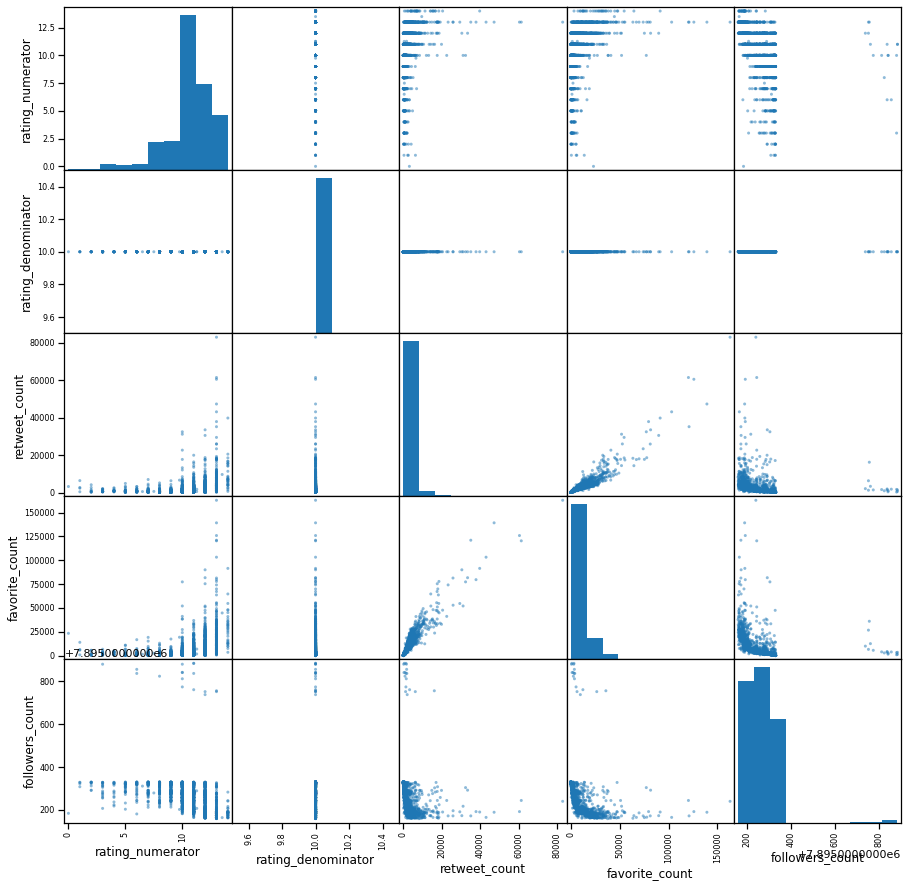

In [209]:
# Investigating Patterns and relationships in arc_df table
pd.plotting.scatter_matrix(arc_df.iloc[:,1:], figsize=(15,15));

From the scatter-matrix we can spot a positive relationship between the retweet_count and favorite_count. Also, it seems that there is some correlation between the rating numerator and both retweet_count and favorite_count.

#### Correlation matrix

In [211]:
arc_df.iloc[:, 1:].corr(method='pearson')

rating_numerator  rating_denominator  retweet_count  \
rating_numerator    1.000000         NaN                  0.299071        
rating_denominator NaN               NaN                 NaN              
retweet_count       0.299071         NaN                  1.000000        
favorite_count      0.396305         NaN                  0.929663        
followers_count    -0.409937         NaN                 -0.270329        

                    favorite_count  followers_count  
rating_numerator    0.396305       -0.409937         
rating_denominator NaN             NaN               
retweet_count       0.929663       -0.270329         
favorite_count      1.000000       -0.413287         
followers_count    -0.413287        1.000000

- As observed from the scatter-matrix, there is a strong positive linear relationship retweet_count and favorite_count `(corr_coeff = 0.9297)`. 
- There's also a moderate positive relationship between the rating_numerator and favorite_count`(corr_coeff = 0.396)`. A weaker postive relationship between the rating_numerator and retweet_count is indicated by the `correlation coefficient = 0.299`

### Retweet Counts & Favorite Counts 

#### Scatter plot between the retweet_count and favorite_count

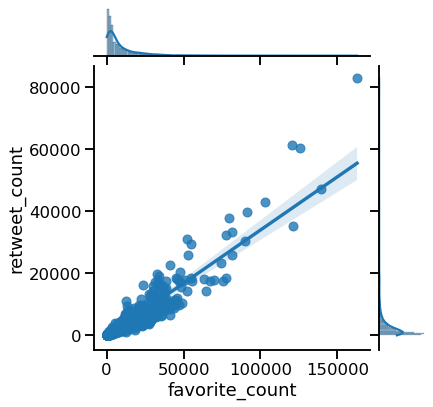

In [213]:
sns.set_context('talk')
def r2(x,y):
    return stats.pearsonr(x,y)[0]**2
sns.jointplot(arc_df.favorite_count, arc_df.retweet_count, kind="reg" )
plt.tick_params(axis="both", labelsize=12);
plt.savefig("retweet_count_favorite_count_corr.png")

Plotting the relation between retweet_count and favorite_count shows with the pearson r^2 of 0.86 illustrates the strong positive relationship between these two variavbles 

Resources:
[Seaborn implot with equation and R2 text](https://stackoverflow.com/questions/25579227/seaborn-implot-with-equation-and-r2-text)

In [214]:
arc_df.loc[:, ['retweet_count', 'favorite_count']].describe()

retweet_count  favorite_count
count  1963.000000    1963.000000   
mean   2637.193072    8693.883851   
std    4709.341040    12757.909021  
min    11.000000      77.000000     
25%    588.500000     1857.500000   
50%    1267.000000    3919.000000   
75%    3011.000000    10840.500000  
max    82868.000000   162834.000000

- I created another dataframe (arc) in which the timestamp column is the index and grouped it by monthly means for smoother plotting of variables like the favorite counts and retweet counts. I such way, i removed the noise of plotting timestamp data.

In [215]:
# for plotting
arc = pd.read_csv('twitter_archive_master.csv', index_col = 'timestamp', parse_dates=True)

In [216]:
arc.index = arc.index.date
arc.index = pd.to_datetime(arc.index, infer_datetime_format=True)
arc = arc.resample('M').mean()

In [217]:
arc.loc[:,['rating_numerator','retweet_count','favorite_count','followers_count']].describe()

rating_numerator  retweet_count  favorite_count  followers_count
count  22.000000         22.000000      22.000000       2.200000e+01   
mean   11.342280         3855.193851    14111.508326    7.895224e+06   
std    1.153121          2096.422081    10055.215666    4.831767e+01   
min    8.908163          492.547619     1152.299320     7.895160e+06   
25%    10.434165         1675.649289    4892.453373     7.895188e+06   
50%    11.433919         4074.063221    11743.363004    7.895210e+06   
75%    12.260795         5456.566898    19449.565522    7.895254e+06   
max    13.000000         7427.119048    35066.500000    7.895326e+06

#### Average retweet_count and favorite_count trend over time span of the data

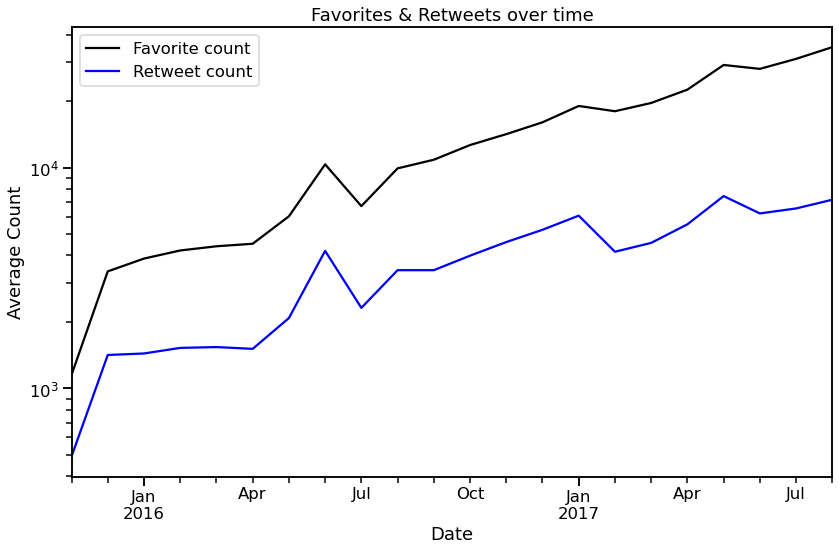

In [218]:
sns.set_context('talk')
arc['favorite_count'].plot(style='k', figsize=(12,8), label='Favorite count');
arc.retweet_count.plot(style='b',label='Retweet count');
plt.legend()
plt.yscale("log")
plt.xlabel("Date");plt.ylabel("Average Count");
plt.title('Favorites & Retweets over time')
plt.tight_layout()
plt.savefig("favorite_Retweet_count_trend.png")

#### Tweets count trend over the dataset time period

In [219]:
arc_timeseries = arc_df.copy()
arc_timeseries = arc_timeseries.set_index('timestamp')
arc_timeseries.sort_index()
master_timeseries = arc_timeseries.reset_index().merge(predictions_df[predictions_df.prediction_level == 1],
         on='tweet_id', how='left').set_index(arc_timeseries.index)

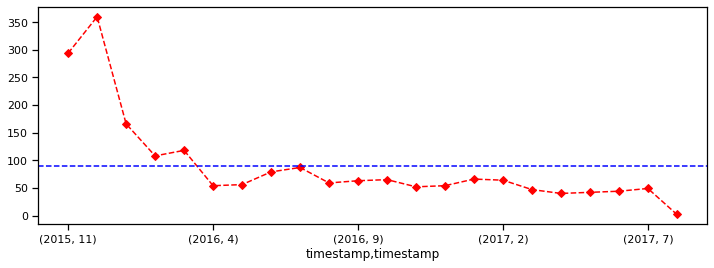

In [220]:
sns.set_context('notebook')
master_timeseries.groupby([(master_timeseries.index.year), (master_timeseries.index.month)]).tweet_id.count().plot(kind='line',  color='r',linestyle='--',
marker='D',figsize=(12,4));
mn=np.mean(master_timeseries.groupby([(master_timeseries.index.year), (master_timeseries.index.month)]).count()['tweet_id'])
plt.axhline(y=mn, color='b', linestyle='--', label='Out of rating')
plt.savefig("tweets_monthly_count_trend.png")

In [221]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1969 non-null   object             
 1   timestamp           1969 non-null   datetime64[ns, UTC]
 2   source              1969 non-null   object             
 3   text                1969 non-null   object             
 4   expanded_urls       1969 non-null   object             
 5   rating_numerator    1968 non-null   float64            
 6   rating_denominator  1968 non-null   float64            
 7   name                1378 non-null   object             
 8   dog_stage           303 non-null    category           
 9   retweet_count       1963 non-null   float64            
 10  favorite_count      1963 non-null   float64            
 11  followers_count     1963 non-null   float64            
dtypes: category(1), datetime64[ns, UTC

#### Exploring the images of rating numerator less that 5

In [222]:
subset = master_timeseries[master_timeseries.rating_numerator < 5]

In [223]:
from PIL import Image
import requests
from io import BytesIO

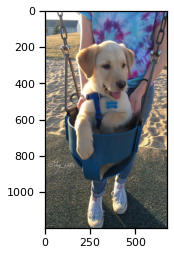

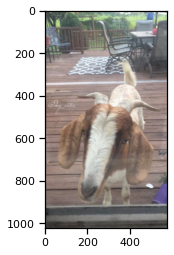

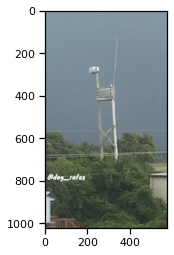

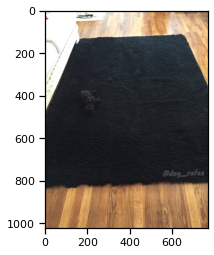

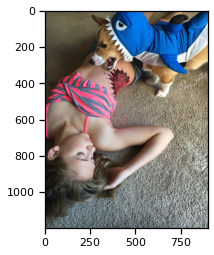

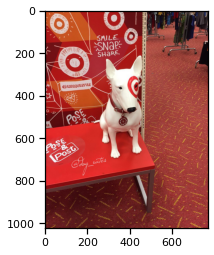

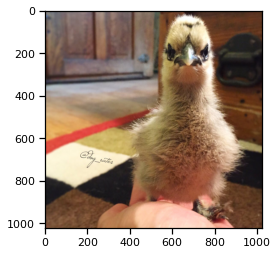

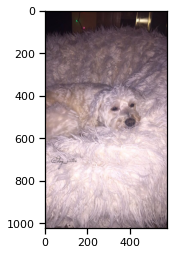

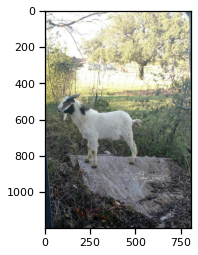

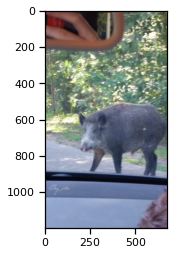

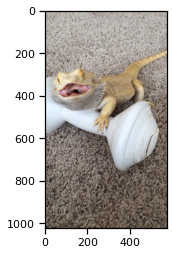

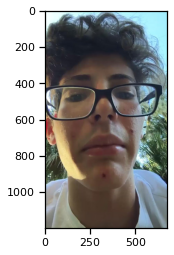

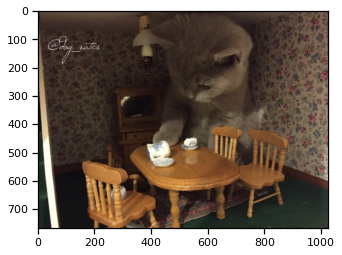

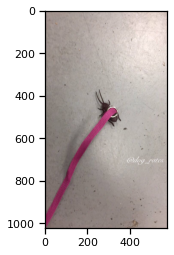

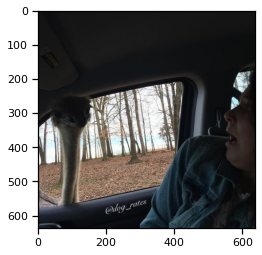

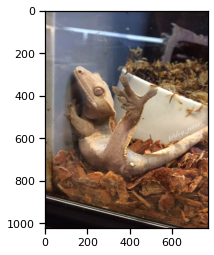

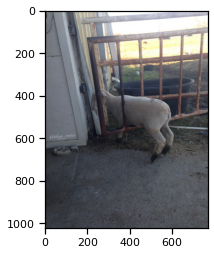

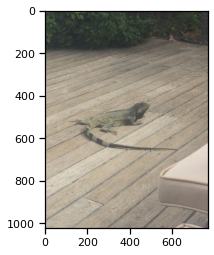

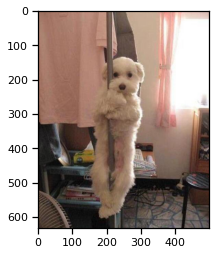

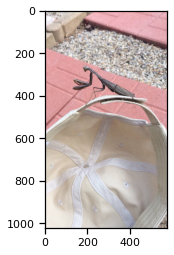

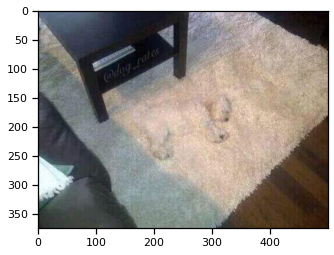

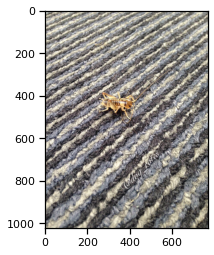

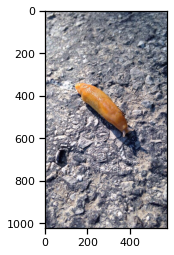

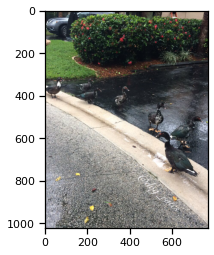

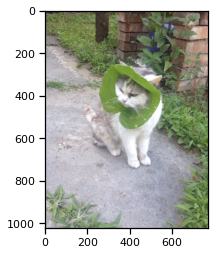

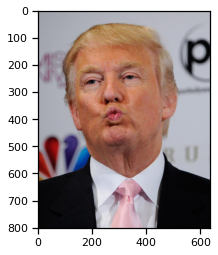

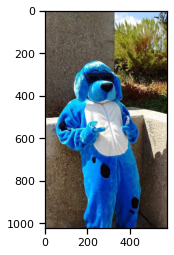

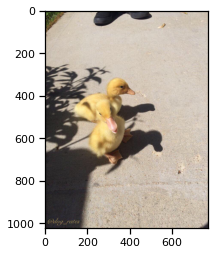

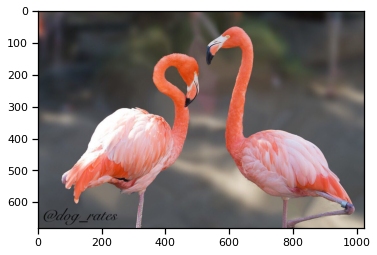

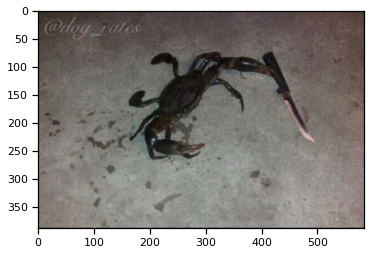

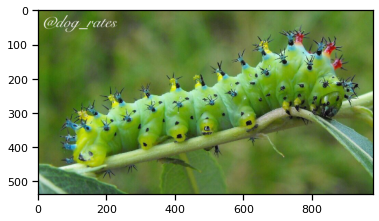

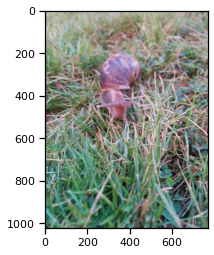

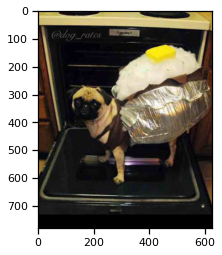

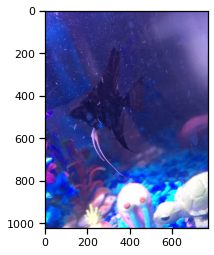

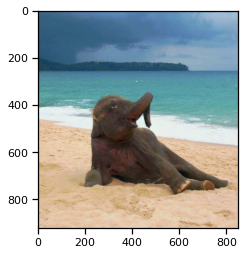

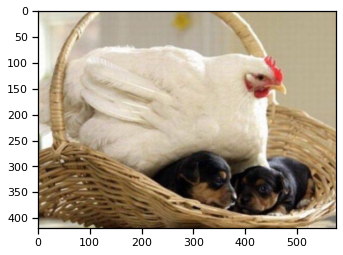

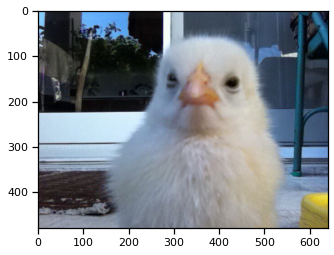

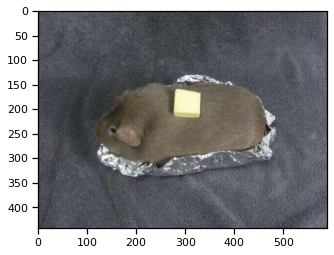

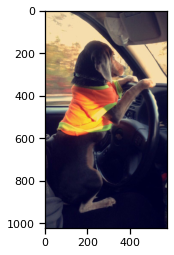

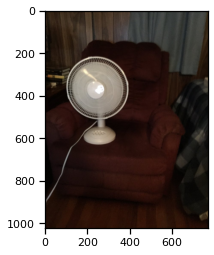

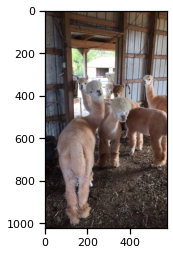

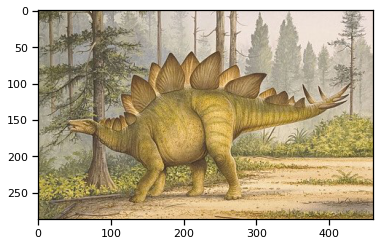

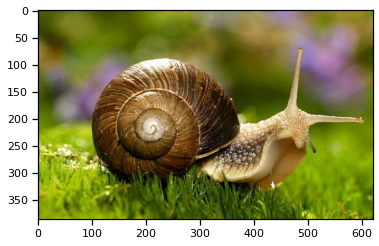

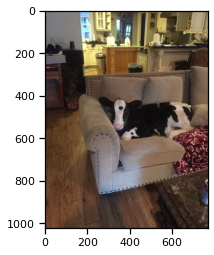

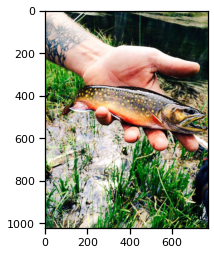

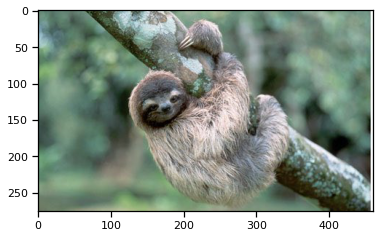

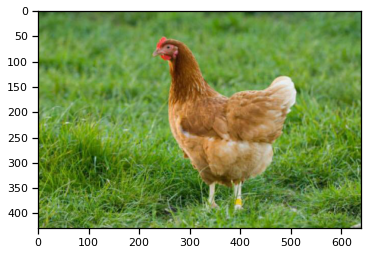

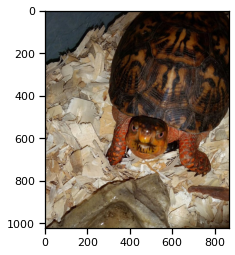

In [224]:
for index, record in subset.iterrows():
    url = record.jpg_url
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    plt.imshow(img)
    plt.show()

#### retweet_count and favorite_count for tweets featuring dogs and those not featuring dogs

In [225]:
master_timeseries.groupby(['dog']).retweet_count.describe()

count         mean          std   min    25%     50%     75%      max
dog                                                                          
False  504.0   2607.154762  4458.740449  32.0  551.0  1059.0  2693.0  37835.0
True   1459.0  2647.569568  4794.300313  11.0  609.5  1350.0  3048.5  82868.0

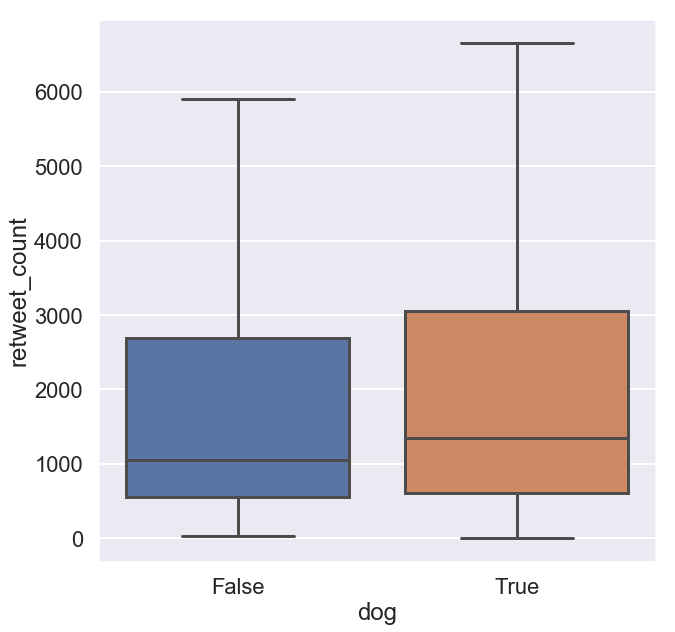

In [287]:
sns.set_context('poster')
ax = sns.boxplot(x='dog', y='retweet_count', data=master_timeseries, showfliers=False)
plt.savefig("boxplots_retweet_count_dogs_not_dogs.png")

[None, None, None, None]

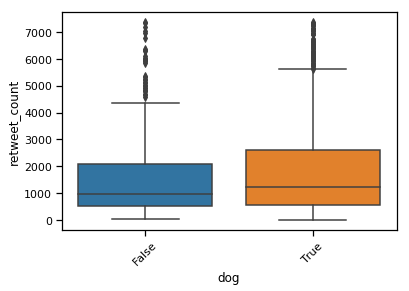

In [196]:
ax = sns.boxplot(x='dog', y='retweet_count',  
                 data=master_timeseries[master_timeseries.retweet_count<7500])

In [197]:
master_timeseries.groupby(['dog']).favorite_count.describe()

count         mean           std    min      25%     50%      75%  \
dog                                                                         
False  504.0   7718.809524  11692.310684  100.0  1428.75  3027.5  9085.0    
True   1459.0  9030.715559  13092.829094  77.0   2101.50  4282.0  11252.5   

            max  
dog              
False  89966.0   
True   162834.0

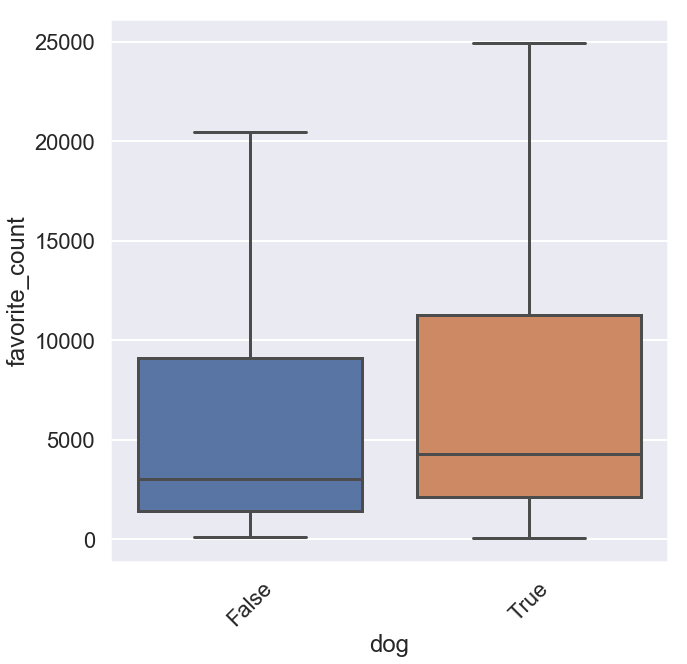

In [288]:
ax = sns.boxplot(x='dog', y='favorite_count', data=master_timeseries, showfliers=False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.savefig("boxplots_favorite_count_dogs_not_dogs.png")

### Rating and their relationship with other variables

#### Rating patterns over time

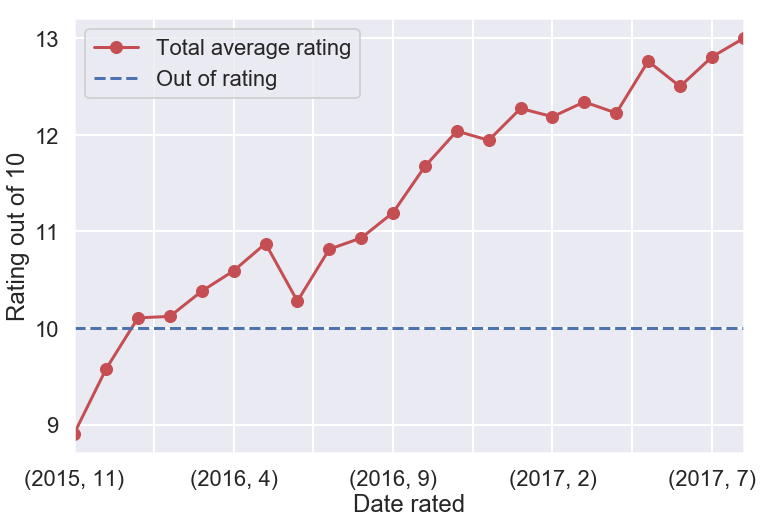

In [290]:
# creating a copy of the arc_df with timestapm as index
sns.set_context('poster')
arc_timeseries = arc_df.copy()
arc_timeseries.index = arc_timeseries['timestamp']
arc_timeseries.drop(columns=['timestamp'], inplace=True)
arc_timeseries.sort_index(inplace=True)
arc_timeseries.groupby([(arc_timeseries.index.year),
                       (arc_timeseries.index.month)]).rating_numerator.mean().plot(style='-ro', figsize=(12,8),label='Total average rating')
plt.axhline(y=10.0, color='b', linestyle='--', label='Out of rating')
plt.xlabel("Date rated");
plt.ylabel("Rating out of 10");
plt.legend();
plt.savefig("Average_Rating_pattern.png")

#### Rating distribution for images featuring dogs and images with no dogs

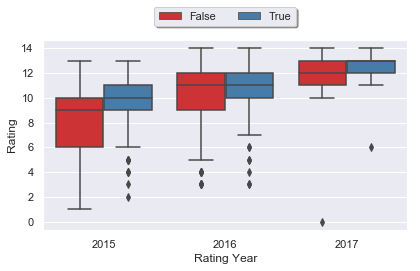

In [292]:
sns.set_context('notebook')
plt.subplots(figsize=(6,4))
sns.boxplot(master_timeseries.index.year, master_timeseries.rating_numerator, hue=master_timeseries.dog, palette="Set1");
plt.legend(loc=8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2)  ,ncol=3, fancybox=True, shadow=True)
plt.xlabel("Rating Year"); plt.ylabel("Rating");
plt.tight_layout()
plt.savefig("Rating_per_year_for_dogs_no_dogs.png")

**Resources**: [How to keep index when using pandas merge](https://stackoverflow.com/questions/11976503/how-to-keep-index-when-using-pandas-merge)

#### Dog Stage distribution

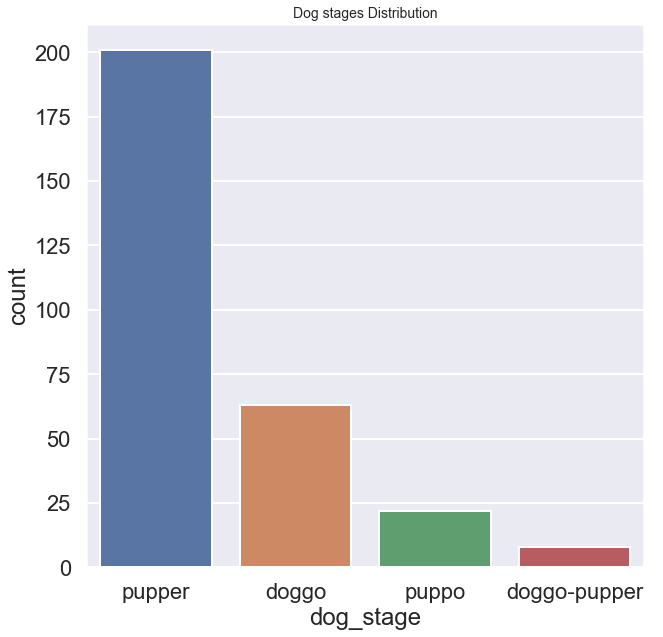

In [295]:
sns.set_context('poster')
ordered_stages = arc_df['dog_stage'].value_counts().head(4).index
sns.countplot(data = arc_df, x = 'dog_stage', order=ordered_stages ,orient = 'h')
plt.title('Dog stages Distribution',fontsize=14)
plt.savefig("Dog_stage_distribution.png");

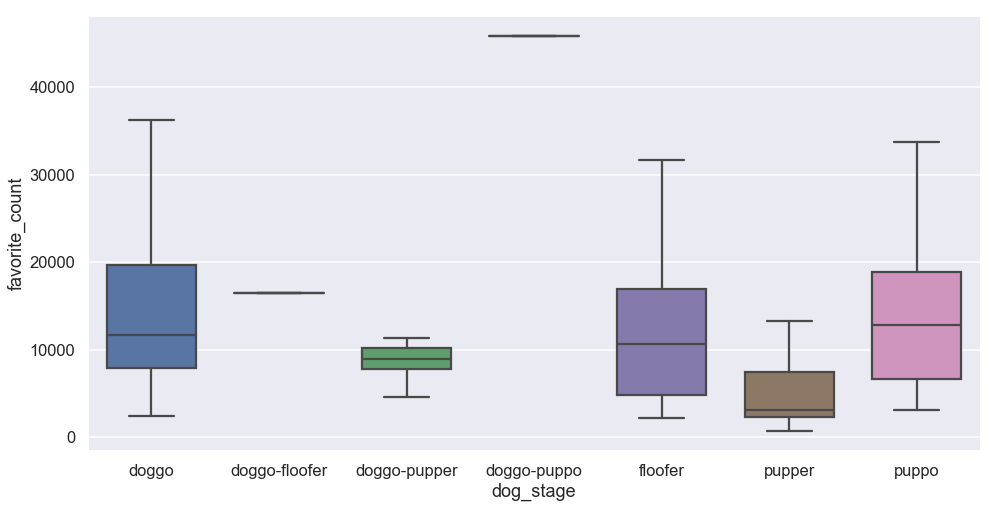

In [318]:
sns.set_context('talk')
ax = sns.boxplot(x='dog_stage', y='favorite_count', showfliers=False, width = .70,
                 data=master_timeseries)
sns.set(rc={'figure.figsize':(8.0,16.0)})
plt.savefig("Dog_stage_favorite_count.png")

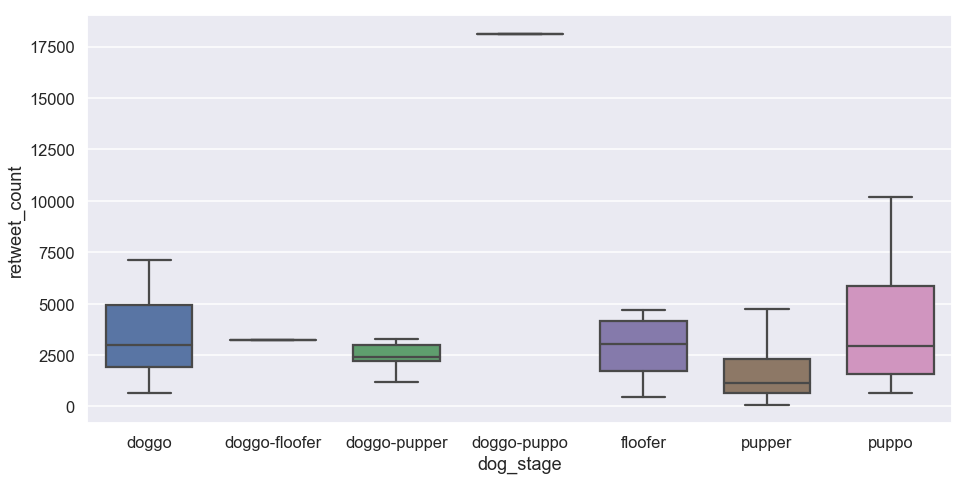

In [346]:
sns.set_context('talk')
ax = sns.boxplot(x='dog_stage', y='retweet_count', showfliers=False, width = .70,
                 data=master_timeseries)
sns.set(rc={'figure.figsize':(15.5, 7.5)});
plt.savefig("Dog_stage_retweet_count.png")

Given the large amount of missing data concerning  this variable, This plot shows that the pupper stage is the most prevalent stage. This may be attributed to the fact that younger puppies are usually more attractive. 

#### Dog stage comparison based on Interaction

In [226]:
avg_retweet_count_dog_stage = arc_df.groupby('dog_stage').retweet_count.mean()
avg_retweet_count_dog_stage.index

CategoricalIndex(['doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo',
                  'floofer', 'pupper', 'puppo'],
                 categories=['doggo', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo', 'floofer', 'pupper', 'puppo'], ordered=False, dtype='category', name='dog_stage')

In [227]:
avg_retweet_count_dog_stage

dog_stage
doggo            7018.983871 
doggo-floofer    3237.000000 
doggo-pupper     4271.625000 
doggo-puppo      18118.000000
floofer          4638.571429 
pupper           2244.303483 
puppo            6219.772727 
Name: retweet_count, dtype: float64

In [228]:
avg_favorite_count_dog_stage = arc_df.groupby('dog_stage').favorite_count.mean()

In [229]:
avg_favorite_count_dog_stage

dog_stage
doggo            19960.225806
doggo-floofer    16430.000000
doggo-pupper     13647.625000
doggo-puppo      45876.000000
floofer          12563.000000
pupper           6998.129353 
puppo            21613.500000
Name: favorite_count, dtype: float64

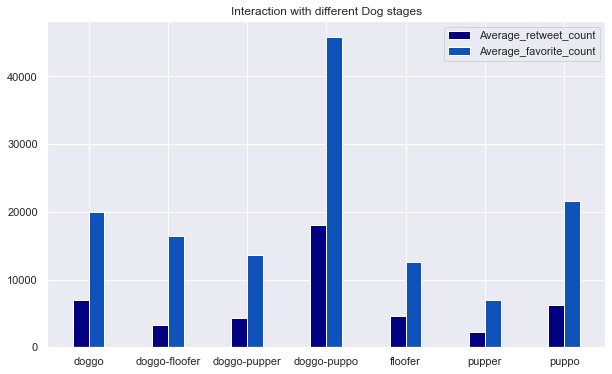

In [230]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
width = 0.2
ind = np.arange(len(avg_favorite_count_dog_stage))
locations = ind + width / 2  # xtick locations
labels = avg_favorite_count_dog_stage.index  # xtick labels


plt.bar(ind, avg_retweet_count_dog_stage, width, color='#000080', label= 'Average_retweet_count')
plt.bar(ind +width , avg_favorite_count_dog_stage, width, color='#0F52BA', label= 'Average_favorite_count')
plt.xticks(locations, labels)
plt.legend()
plt.title("Interaction with different Dog stages");

#### Glimpse on Breeds

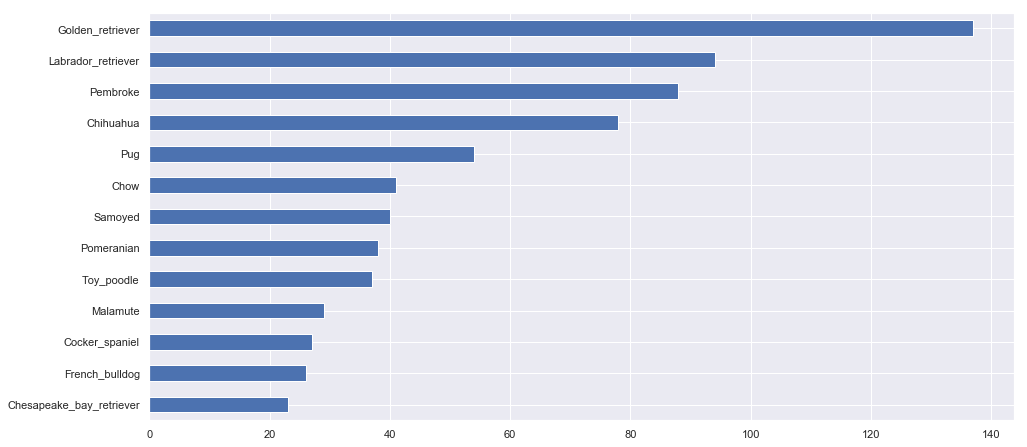

In [347]:
master_timeseries[master_timeseries.dog == True].prediction.value_counts()[12::-1].plot(kind='barh');
plt.savefig("Top_Breeds_Distribution.png")

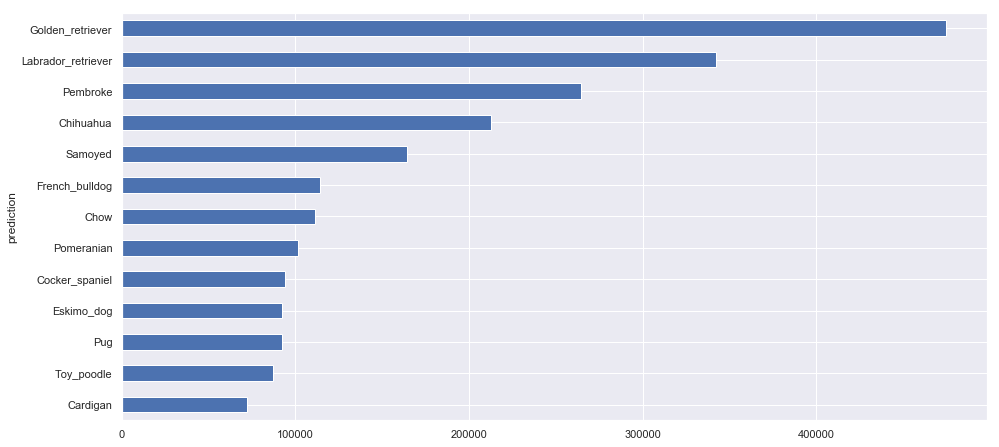

In [348]:
master_timeseries[master_timeseries.dog == True].groupby(['prediction']).retweet_count.sum().sort_values(ascending=False)[12::-1].plot(kind='barh');
plt.savefig("Top_Breeds_Retweet_Count.png")

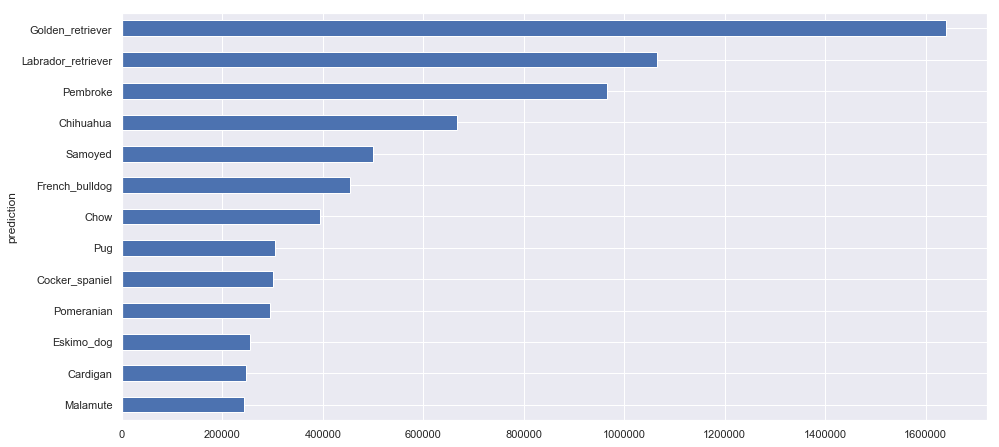

In [349]:
master_timeseries[master_timeseries.dog == True].groupby(['prediction']).favorite_count.sum().sort_values(ascending=False)[12::-1].plot(kind='barh');
plt.savefig("Top_Breeds_Favorite_count.png")

In [231]:
master_timeseries[master_timeseries.dog == True].groupby(['prediction']).favorite_count.mean().sort_values(ascending=False)[12::-1]

prediction
Lakeland_terrier           13410.066667
Eskimo_dog                 14129.277778
Leonberg                   14183.666667
Cardigan                   14565.529412
English_springer           14951.555556
Standard_poodle            15103.857143
Irish_water_spaniel        15592.000000
Flat-coated_retriever      16054.000000
Black-and-tan_coonhound    16250.000000
Afghan_hound               16429.333333
Giant_schnauzer            16433.000000
French_bulldog             18178.320000
Saluki                     23055.250000
Name: favorite_count, dtype: float64

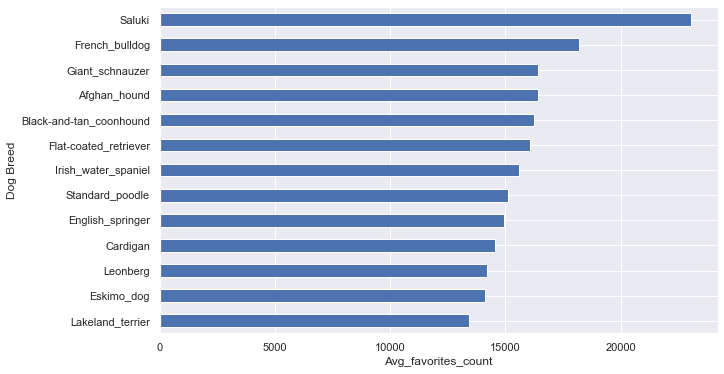

In [232]:
sns.set_context('notebook')
master_timeseries[master_timeseries.dog == True].groupby(['prediction']).favorite_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh');
plt.xlabel('Avg_favorites_count')
plt.ylabel('Dog Breed');
plt.savefig("Top_Breeds_Average_Favorite_count.png")

#### Followers Insight

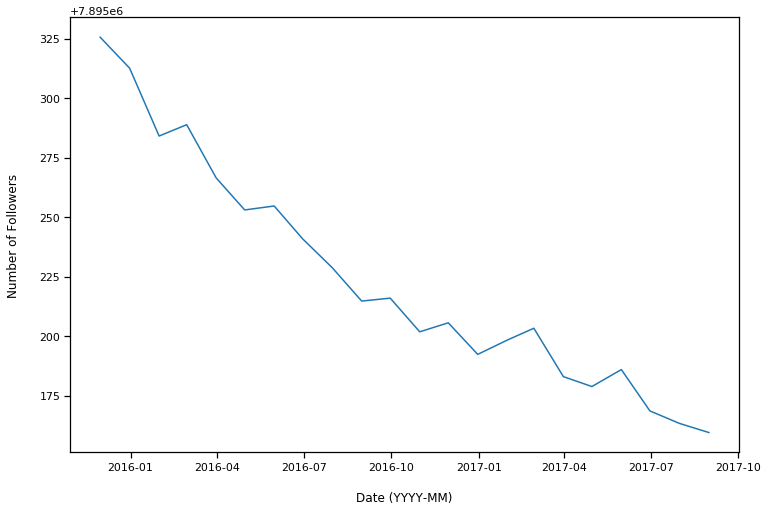

In [205]:
plt.subplots(figsize=(12, 8))
plt.plot(arc.followers_count)
plt.xlabel('\nDate (YYYY-MM)')
plt.ylabel('Number of Followers\n');
plt.savefig('followers_decline.png')

I will stop here, yet definitly there are a ton of insights to glean and analyse...!